# Analyze single cell tracks

Analyze cell motility in the osteogenic front. Input data consists of manually tracked xy-positions of individual cells, both near the front as well as in the bulk away from the front.

### Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import ceil
import seaborn as sns
cwd = os.getcwd(); print("Working dir: " + cwd)

folder_figures = "/Users/dang/Documents/TablerLab/Figures/Cell_tracks_Adrian/";
im_label = "Cell_tracks_analyzed_"

Working dir: /Users/dang/Documents/TablerLab/Code


In [2]:
# --- Input parameters ---
video_labels = ["190305", "190314", "200120", "020917"];
pix_per_micron_all = [4.400, 5.1040, 5.1040, 4.4034]; # Number of pixels per micron
names_compare = ["Bone Front", "In Bone", "Further In Bone"];
video_image_sizes = np.array([[859.55, 655], [1099.53, 562.5], [927.51, 769.01], [1054.42, 655.50] ]); # in microns
delta_t = 1/6; # time interval between slices in hrs

In [3]:
# Load files
data_path = "/Users/dang/Documents/TablerLab/Data_Adrian_cell_tracks/";
fname_templates = ["Results from MaxProjected_Stitched_Blurred_190305 ML1 OsxGFP Explant Video 1 (0-12hr) in um per min.csv",
                  "Results from MaxProjected_Stitched_Blurred_190314 ML1 OsxGFP Explant Video 1 (0-8hr) in um per sec.csv",
                   "Results from MaxProjected_Stitched_Blurred_200120 Live Imaging OsxGFP E1375 12 hours in um per sec.csv",
                  "Results from MAX_BLUR_20200414AQR_osx_E13 in um per min.csv"]
filenames_all = [["{} {}".format(x,y) for x in names_compare] for y in fname_templates ];
N_videos = len(fname_templates);
N_files_per_video = len(names_compare);
video_image_sizes_pix = [[int(pix_per_micron_all[i]*video_image_sizes[i, j]) for j in range(2)] for i in range(N_videos)]; # in pixels

loaded_data_all = [[None]*N_files_per_video for _ in range(N_videos)];
for i in range(N_videos):    
    subfolder = "Video {}/".format(i+1);
    for j in range(N_files_per_video):
        loaded_data_all[i][j] = pd.read_csv(data_path+subfolder+filenames_all[i][j]);

### Process data

In [4]:
# Total number of cells
N_cells_all = [ [len(np.unique(loaded_data_all[i][j].Track)) for j in range(N_files_per_video) ] for i in range(N_videos)];
print("Number of cells = " + str(N_cells_all))

# Number of slices per cell
N_slices_all = [ [len(np.unique(loaded_data_all[i][j].Slice)) for j in range(N_files_per_video)] for i in range(N_videos)];
print("Number of slices(=frames) per cell = " + str(N_slices_all))

Number of cells = [[46, 23, 36], [47, 31, 34], [52, 24, 39], [54, 39, 30]]
Number of slices(=frames) per cell = [[73, 73, 73], [49, 49, 49], [73, 73, 73], [85, 85, 85]]


In [5]:
X_all_all = [[None]*N_files_per_video for _ in range(N_videos)];
Y_all_all = [[None]*N_files_per_video for _ in range(N_videos)];
tracks_all_all = [[None]*N_files_per_video for _ in range(N_videos)];

for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        loaded_data = loaded_data_all[i1][i2];
        N_cells = N_cells_all[i1][i2];
        N_slices = N_slices_all[i1][i2];
        
        # Extract X and Y coordinates for each cell
        X_all = np.nan*np.zeros([N_cells, N_slices]);
        Y_all = np.nan*np.zeros([N_cells, N_slices]);
        tracks_all = np.unique(loaded_data.Track); # Cell track numbers

        for i in range(len(tracks_all)):
            track = tracks_all[i];
            # select cell i
            data_cell_i = loaded_data.loc[loaded_data.Track == track];
            slices_cell_i = data_cell_i.Slice-1;

            # store data
            X_all[i, slices_cell_i] = data_cell_i.X;
            Y_all[i, slices_cell_i] = data_cell_i.Y; 

        X_all_all[i1][i2] = X_all;
        Y_all_all[i1][i2] = Y_all;
        tracks_all_all[i1][i2] = tracks_all;           

In [6]:
# For plotting:
slices_all_all = [ [np.array([range(N_slices_all[i1][i2]) for i in range(N_cells_all[i1][i2])])/6 
                    for i2 in range(N_files_per_video)] for i1 in range(N_videos)];
# time range to plot
t_lower = 0; # starting time in hrs
t_upper = 6; # final time in hrs
slice_range = np.arange(t_lower*6, t_upper*6+1); # hours*6
#slice_range = range(Nslices) #full range

# colors for categories
#colors_cats = ['gray', 'pink', 'black'];
colors_cats = [(0, 0, 0),  (1/3, 1/3, 1/3), (2/3, 2/3, 2/3)];

# system default colors
prop_cycle = plt.rcParams['axes.prop_cycle']
def_colors = prop_cycle.by_key()['color'];

## Plot all 2D cell tracks
This effectively recovers the tracks as shown in the videos.

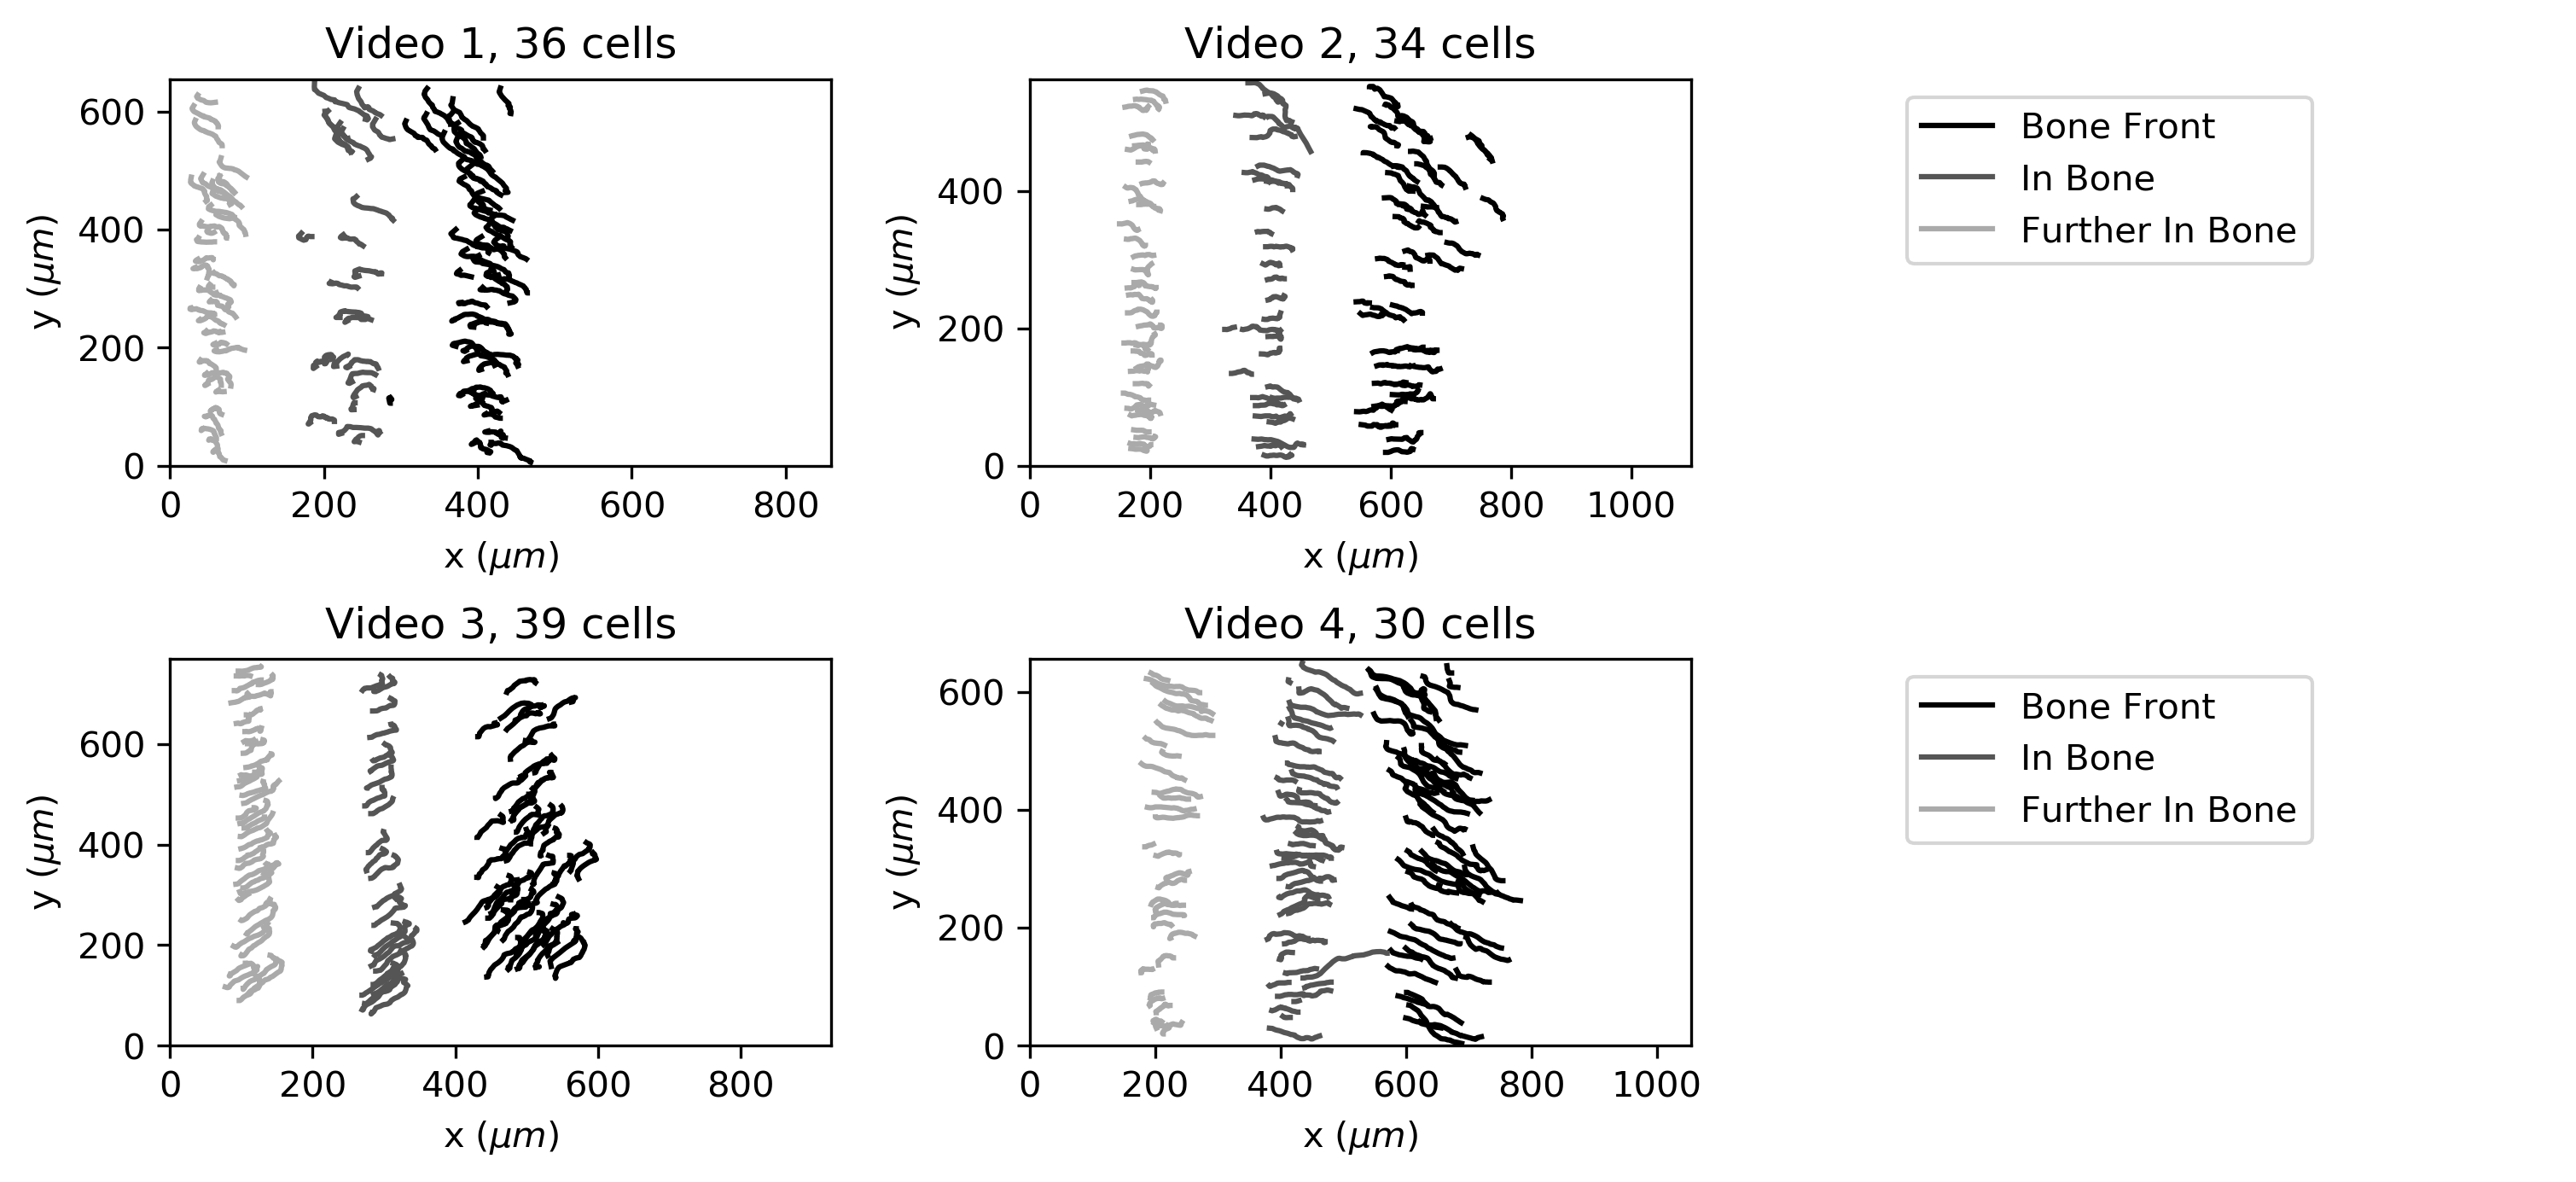

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(12, 5), dpi=300)

for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    [ix, iy] = divmod(i1, 2);
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2];
        Y_all = Y_all_all[i1][i2];  
        N_cells = N_cells_all[i1][i2];
        
        axs[ix, iy].plot(X_all[:, slice_range].T/pix_per_micron, Y_all[:, slice_range].T/pix_per_micron, color=colors_cats[i2]);
        #this_title = 'Video {} ({}) {}, {} cells'.format(i1+1, video_labels[i1], names_compare[i2], str(N_cells));
        #this_title = 'Video {}, {}, {} cells'.format(i1+1, names_compare[i2], str(N_cells));
        this_title = 'Video {}, {} cells'.format(i1+1, str(N_cells));
        this_size = video_image_sizes[i1];
        axs[ix, iy].set(xlabel='x ($\\mu m$)', ylabel='y ($\\mu m$)', title=this_title, xlim=[0, this_size[0]], ylim=[0, this_size[1]])

plt.subplots_adjust(hspace=0.5, wspace=0.3)

# ---- Legend ----
for row in range(2):
    for i, this_label in enumerate(names_compare):
        axs[row, 2].plot(np.nan, label=this_label, color=colors_cats[i])
    axs[row, 2].legend(loc='upper left')
    axs[row, 2].axis('off')
    
plt.show()

## Tracked cells over time
The number of cells which are tracked typically decreases over time, because it is not possible to follow all cells until the end of the video. Hence the averages above are taken over fewer and fewer cells as time progresses, leading to larger uncertainties. Below we plot the number of tracked cells over time for reference.

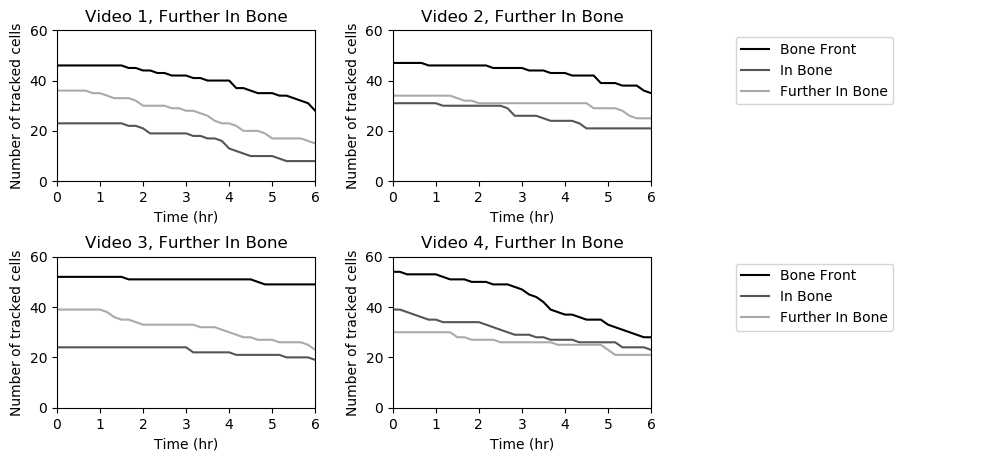

In [8]:
from math import ceil
fig, axs = plt.subplots(2, 3, figsize=(12, 5), dpi=100); #plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)

for i1 in range(N_videos):
    [ix, iy] = divmod(i1, 2);
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2];
        slices_all = slices_all_all[i1][i2];
        
        N_tracked_cells_vs_t = np.sum(~np.isnan(X_all), axis=0);        
        
        axs[ix, iy].plot(slices_all[0,:], N_tracked_cells_vs_t, color=colors_cats[i2])
        #this_title = 'Video {} ({}) {}'.format(i1+1, video_labels[i1], names_compare[i2]);
        this_title = 'Video {}, {}'.format(i1+1, names_compare[i2]);
        # ylim_up = ceil(N_tracked_cells_vs_t[0]/10)*10;
        axs[ix, iy].set(xlabel='Time (hr)', ylabel='Number of tracked cells', title=this_title)
        axs[ix, iy].set(xlim=[t_lower, t_upper], ylim = [0, 60])
        
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# ---- Legend ----
for row in range(2):
    for i, this_label in enumerate(names_compare):
        axs[row, 2].plot(np.nan, label=this_label, color=colors_cats[i])
    axs[row, 2].legend(loc='upper left')
    axs[row, 2].axis('off')
plt.show()


# Cell velocities

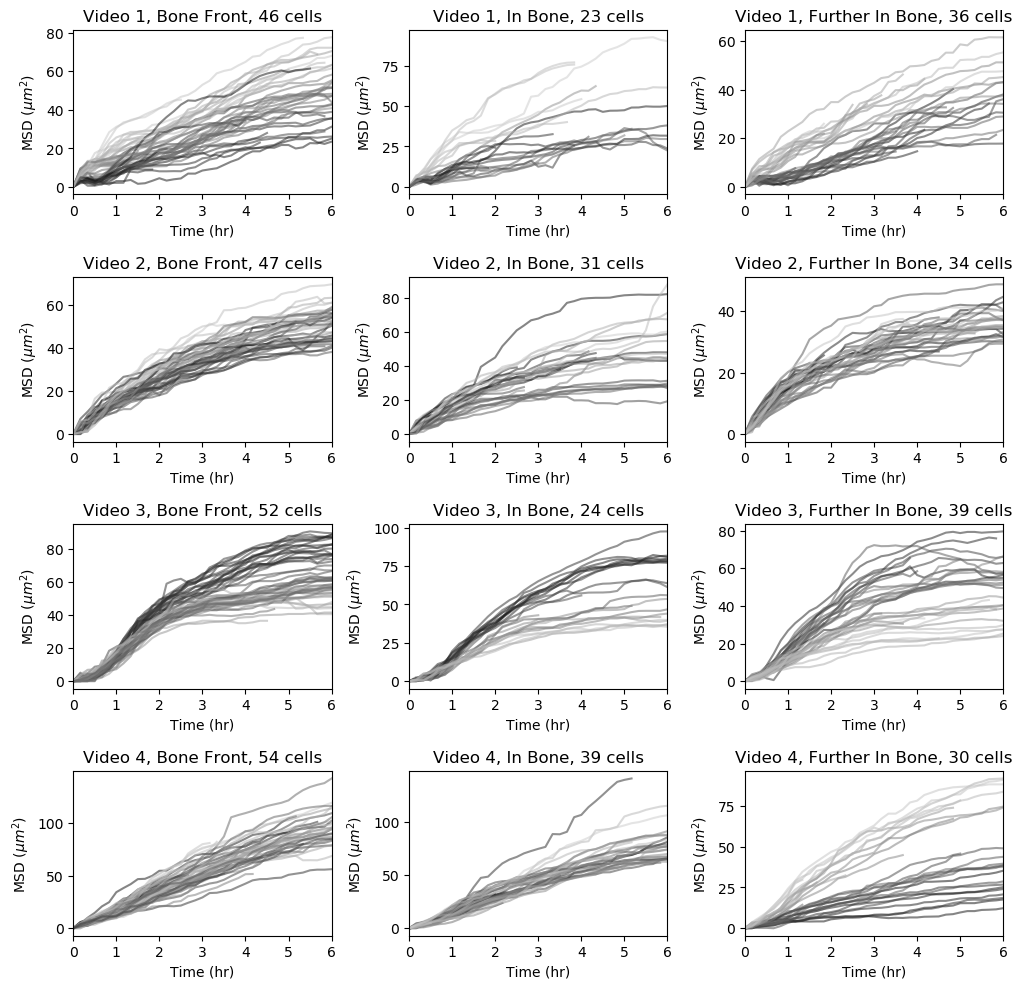

Lighter colors = higher Y values


In [15]:
# Plot displacements in vs t

# Calculate RMSD for all cells
v_time_ranges = np.array([[0, 4]]); #, [0, 6]]); # in hours
RSMD_df = pd.DataFrame([], columns=["Video", "Location", "Time1", "Time2", "Y0", "Velocity"])

counter = 0; # for adding elements to df
fig, axs = plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)
for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2][:,slice_range];
        Y_all = Y_all_all[i1][i2][:,slice_range];
        N_cells = N_cells_all[i1][i2];
        slices_all = slices_all_all[i1][i2][:, slice_range];
        Y0_all = Y_all[:, 0]/pix_per_micron; #/video_image_sizes_pix[i1][1];
        Y0_rescaled_all = Y_all[:, 0]/video_image_sizes_pix[i1][1];
        
        RMSD_all = np.array(list(map( lambda X, Y: np.sqrt( (X-X[0])**2 + (Y-Y[0])**2), X_all, Y_all)))/pix_per_micron; # units: microns^2
        
        # Calculate velocities over specified time ranges
        for i3 in range(len(v_time_ranges)):
            time_range = np.round(6*v_time_ranges[i3]);
            v_cells_all = (RMSD_all[:, int(time_range[1])] - RMSD_all[:, int(time_range[0])])/(np.diff(time_range/6)[0]);
            cells_slice = ~np.isnan(v_cells_all);
            v_cells = v_cells_all[cells_slice];
            Y0_cells = Y0_all[cells_slice];
            
            for i4 in range(len(v_cells)):
                RSMD_df.loc[counter] = [i1+1, names_compare[i2], time_range[0], time_range[1], Y0_cells[i4], v_cells[i4]]
                counter += 1;
        
        # -- Plot everything with same or default colors --
        #axs[i1, i2].plot(slices_all.T, RMSD_all.T)
        
        # -- Plot with colors depending on initial Y position -- 
        for j in range(slices_all.shape[0]):
            this_color = 0.8*np.ones(3)*Y0_rescaled_all[j];
            axs[i1, i2].plot(slices_all[0], RMSD_all[j, :], color=this_color, alpha=0.5);
        
        #this_title = 'Video {} ({}) {}, {} cells'.format(i1+1, video_labels[i1], names_compare[i2], str(N_cells));
        this_title = 'Video {}, {}, {} cells'.format(i1+1, names_compare[i2], str(N_cells));
        axs[i1, i2].set(xlabel='Time (hr)', ylabel='MSD ($\\mu m^2$)', title=this_title, xlim=[t_lower, t_upper])

plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show()

print("Lighter colors = higher Y values")

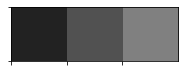

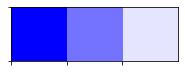

In [78]:
# Choose color palette
# pal = sns.cubehelix_palette(3, start=1.5, rot=-.75);
pal = sns.dark_palette('gray', n_colors=3, reverse=False)
pal2 = sns.light_palette('blue', n_colors=3, reverse=True);
sns.palplot(pal)
sns.palplot(pal2)

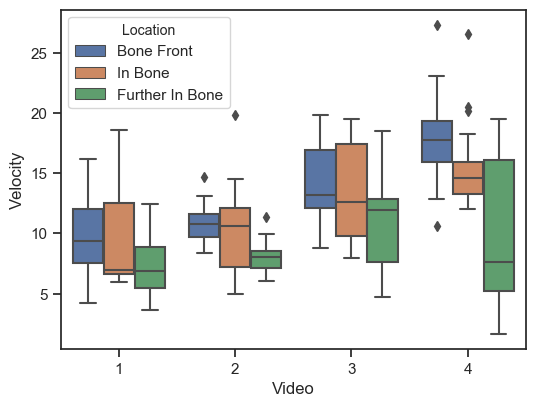

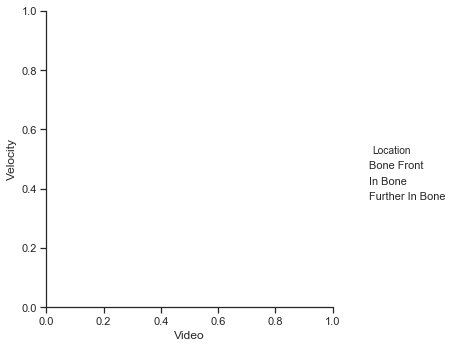

In [131]:
# Select data
k=0;
time_range = v_time_ranges[k]
slice_bool = (RSMD_df.Time1 == np.round(time_range[0]*6) ) & (RSMD_df.Time2 == np.round(time_range[1]*6) )
RSMD_df_sel = RSMD_df[slice_bool];

# Plot options
plt.ioff()
sns.set(font_scale=1, style="ticks")

# Default seaborn plotting 
fig, ax = plt.subplots(figsize=(4*1.5,3*1.5), dpi=100)
# scatter plot 
#g = sns.catplot(x="Video", y="Velocity", hue='Location', kind='swarm', data=RSMD_df_sel,  palette=pal, ax=ax)
# box plot
g = sns.catplot(x="Video", y="Velocity", kind="box", hue='Location', data=RSMD_df_sel, ax=ax )

# Plot data
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(4*2, 3*2), dpi=300)
# plt.subplots_adjust(hspace=0.4, wspace=0.3)
# for ix in range(2):
#     for iy in range(2):
#         i = 2*(ix) + (iy); 
#         this_data = RSMD_df_sel[RSMD_df_sel['Video'] == i+1];
        
#         # scatter / swarm
#         g = sns.catplot(x="Location", y="Velocity", data=this_data, palette=pal, ax=ax[ix, iy])
        
#         # box plot
#         #g = sns.catplot(x="Location", y="Velocity", kind="box", data=this_data, palette=pal, ax=ax[ix, iy])
        
#         # set labels
#         ax[ix,iy].set_ylabel('Velocity ($\mu m$/hr)')
#         ax[ix,iy].set_ylim([0, 25])
#         ax[ix,iy].set_title('Video {}'.format(i+1) )

# restore defaults
plt.ion()
sns.set(font_scale=1)

# Plot mean-squared displacement

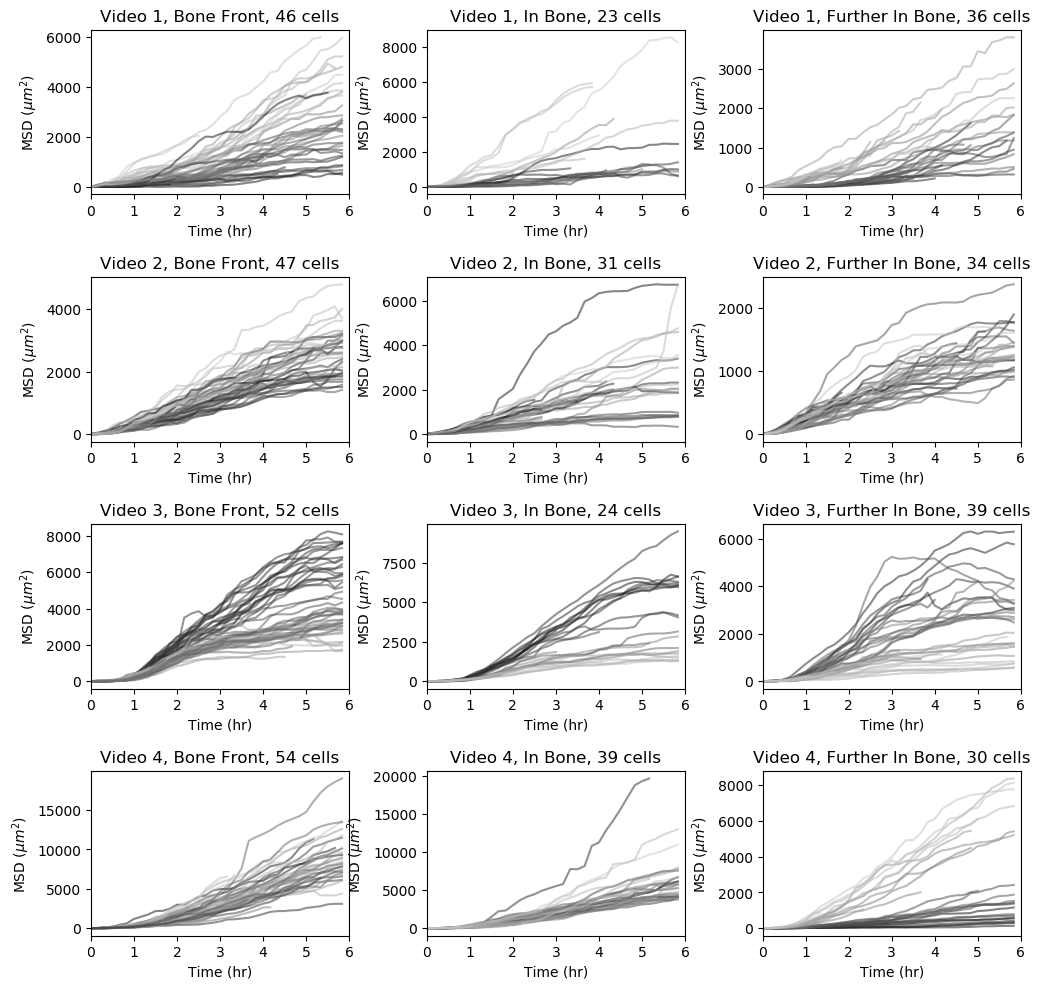

Lighter colors = higher Y values


In [229]:
# Plot MSD vs t for individual cells
fig, axs = plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)
for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2][:,slice_range];
        Y_all = Y_all_all[i1][i2][:,slice_range];
        N_cells = N_cells_all[i1][i2];
        slices_all = slices_all_all[i1][i2][:, slice_range];
        Y0_rescaled_all = Y_all[:, 0]/video_image_sizes_pix[i1][1];
        
        MSD_all = np.array(list(map( lambda X, Y: (X-X[0])**2 + (Y-Y[0])**2 , X_all, Y_all)))/pix_per_micron**2; # units: microns^2
        
        # -- Plot everything with same or default colors --
        #axs[i1, i2].plot(slices_all.T, MSD_all.T)
        
        # -- Plot with colors depending on initial Y position -- 
        for i3 in range(slices_all.shape[0]):
            this_color = 0.8*np.ones(3)*Y0_rescaled_all[i3];
            axs[i1, i2].plot(slices_all[0], MSD_all[i3, :], color=this_color, alpha=0.5);
        
        #this_title = 'Video {} ({}) {}, {} cells'.format(i1+1, video_labels[i1], names_compare[i2], str(N_cells));
        this_title = 'Video {}, {}, {} cells'.format(i1+1, names_compare[i2], str(N_cells));
        axs[i1, i2].set(xlabel='Time (hr)', ylabel='MSD ($\\mu m^2$)', title=this_title, xlim=[t_lower, t_upper])

plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show()

print("Lighter colors = higher Y values")

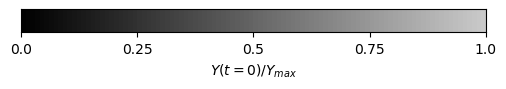

In [298]:
#manually make colorbar
max_gray = 0.8;
y_size = 5;
x_all = np.arange(0,1,0.01);
colors_all = np.array([[max_gray*np.array([1,1,1])*f for f in x_all] for _ in range(y_size) ]);
plt.figure(dpi=100)
plt.imshow(colors_all)
plt.xlabel('$Y(t=0)/Y_{max}$')
xtick_vals = np.linspace(0, len(x_all), 5);
plt.xticks( xtick_vals )
x_tick_labels = [ str(xtick_vals[i]/len(x_all)) for i in range(len(xtick_vals))];
plt.xticks(ticks=xtick_vals-0.5, labels=x_tick_labels)
plt.xlim([-0.5,len(x_all)-0.5])
plt.yticks([])
plt.show()

Blue shaded area = standard error of the mean
Grey shaded area = standard deviation of data set


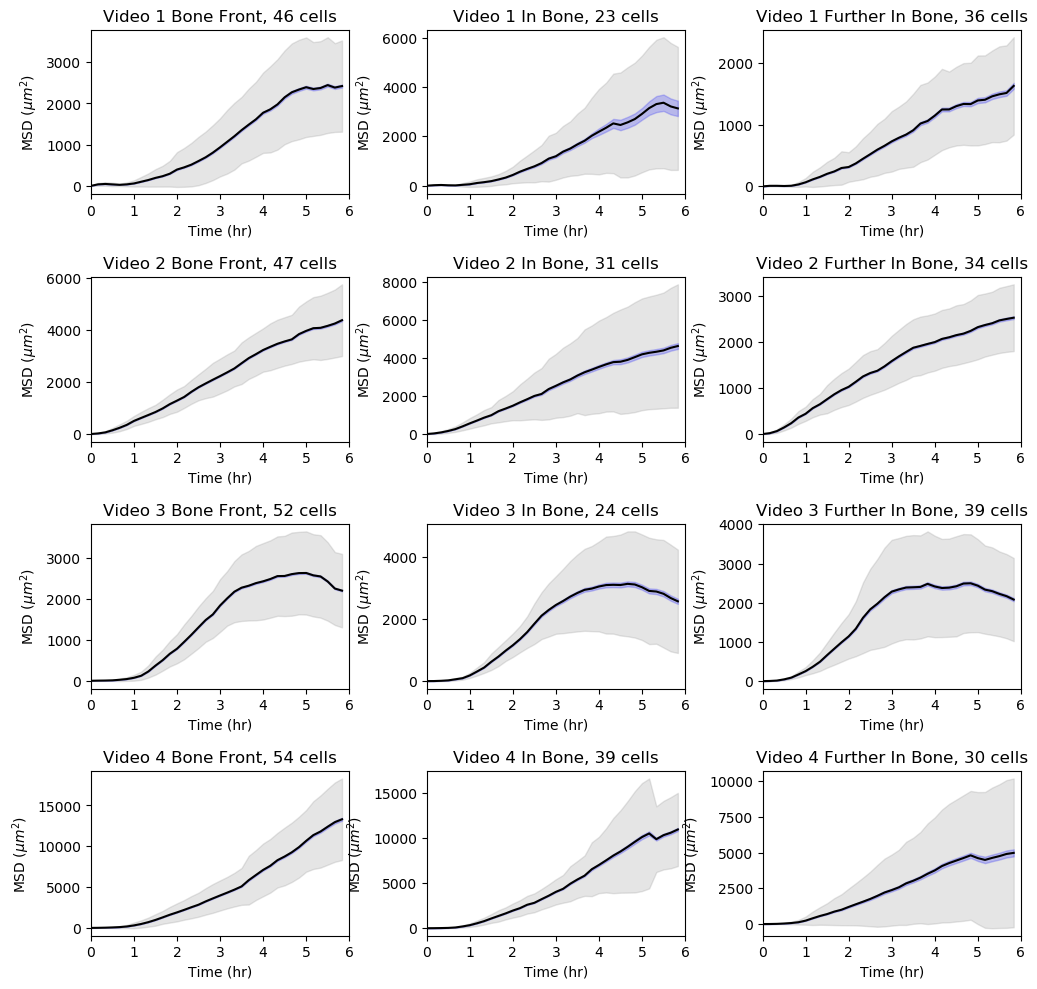

In [10]:
# --- Average over all cells ---
# store for later
MSD_avg_all = [[None]*N_files_per_video for _ in range(N_videos)];
sem_all_all = [[None]*N_files_per_video for _ in range(N_videos)];

# Plot MSD vs t
fig, axs = plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)
for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2][:, slice_range];
        Y_all = X_all_all[i1][i2][:, slice_range];
        N_cells = N_cells_all[i1][i2];
        slices = slices_all_all[i1][i2][0, slice_range];
        
        # Compute mean
        MSD_all = np.array(list(map( lambda X, Y: (X-X[0])**2 + (Y-Y[0])**2 , X_all, Y_all)))/pix_per_micron**2; # units: microns^2
        MSD_avg = np.nanmean(MSD_all, axis=0);
        
        # Compute SEM
        std_all = np.nanstd(MSD_all, axis=0); # Std for each time point
        n_all = np.sum(~np.isnan(MSD_all), axis=0); # no. data points per time point
        sem_all = std_all/n_all;
        
        # store results
        MSD_avg_all[i1][i2] = MSD_avg;
        sem_all_all[i1][i2] = sem_all;
        
        axs[i1, i2].plot(slices, MSD_avg, color='k')
        axs[i1, i2].fill_between(slices, MSD_avg+std_all, MSD_avg-std_all, alpha=0.2, color='gray')
        axs[i1, i2].fill_between(slices, MSD_avg+sem_all, MSD_avg-sem_all, alpha=0.2, color='b')
        #this_title = 'Video {} ({}) {}, {} cells'.format(i1+1, video_labels[i1], names_compare[i2], str(N_cells));
        this_title = 'Video {} {}, {} cells'.format(i1+1, names_compare[i2], str(N_cells));
        axs[i1, i2].set(xlabel='Time (hr)', ylabel='MSD ($\\mu m^2$)', title=this_title, xlim=[t_lower, t_upper])

plt.subplots_adjust(hspace=0.5, wspace=0.3)

# print("Net mean velocity over {} hours = {} microns/hr".format(t_upper, round(X_displacements_avg[-1]/t_upper)) )
print("Blue shaded area = standard error of the mean")
print("Grey shaded area = standard deviation of data set")

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

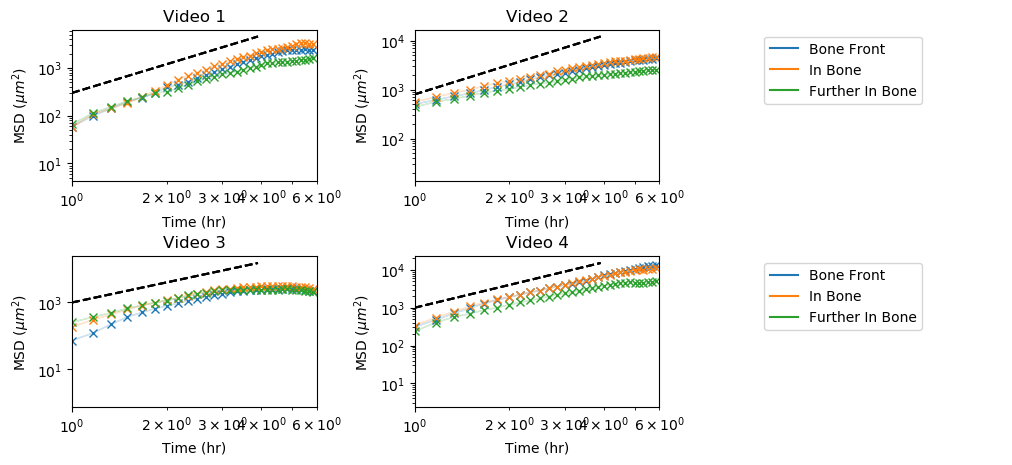

In [300]:
# --- Same data as previous plots, but now directly compare bone front and in bone ---
fig, axs = plt.subplots(2, 3, figsize=(12, 5), dpi=100);

c1_all = [300, 800, 1000, 1000]; # slopes of scaling laws 
c2_all = [150, 300, 200, 400];
colors_2 = [(0,0,0), (0.5,0.5,0.5)]
for i1 in range(N_videos):
    [ix, iy] = divmod(i1, 2); # positions of plots
    for i2 in range(N_files_per_video):
        slices = slices_all_all[i1][i2][0, slice_range];
        
        plt.sca(axs[ix, iy])
        plt.plot(slices, MSD_avg_all[i1][i2], 'x', label=names_compare[i2], color=def_colors[i2])
        plt.fill_between(slices, MSD_avg_all[i1][i2]+sem_all_all[i1][i2], MSD_avg_all[i1][i2]-sem_all_all[i1][i2], alpha=0.2, color=def_colors[i2])
        this_title = 'Video {}'.format(i1+1);
        plt.xlabel('Time (hr)')
        plt.ylabel('MSD ($\\mu m^2$)')
        plt.title(this_title)        
        plt.yscale('log')
        plt.xscale('log');
        plt.xlim(1, 6)
       
        # plot lines with scaling
        t1_plot = np.arange(1, 4, 0.1);
        y1_plot = c1_all[i1]*t1_plot**2;
        t2_plot = np.arange(3, 6, 0.1);
        y2_plot = c2_all[i1]*t2_plot;
        axs[ix, iy].plot(t1_plot, y1_plot, '--', color=colors_2[0])
        #axs[ix, iy].plot(t2_plot, y2_plot, '--', color=colors_2[1])
        
    #axs[i1].set( title= 'Video {} ({})'.format(i1+1, video_labels[i1]), xlabel='Time (hr)', ylabel='$\\langle x(t) - x(0) \\rangle$ ($\\mu m$)'  )
    #axs[ix, iy].set( title= 'Video {}'.format(i1+1), xlabel='Time (hr)', ylabel='MSD ($\\mu m^2$)'  )
    #axs[i1].legend();
# plt.show()
plt.subplots_adjust(wspace=0.4, hspace=0.5)

# ---- Legend ----
#plt.figure(dpi=100, figsize = (2, 1) )
for row in range(2):
    for i, this_label in enumerate(names_compare):
        axs[row, 2].plot(np.nan, label=this_label, color=def_colors[i])
    axs[row, 2].legend(loc='upper left')
    axs[row, 2].axis('off')

# save figure
# fname_out = folder_figures + im_label + "MSD_average";
# label = '_all_videos_log_log_compare_t2';
# plt.savefig(fname_out + label + ".pdf")
# plt.savefig(fname_out + label + ".eps")   

plt.show()

# ---- Legend ----
# plt.figure(dpi=100, figsize = (2, 1) )
# for i, this_label in enumerate(names_compare):
#     plt.plot(np.nan, label=this_label)
# plt.axis('off')
# plt.legend()
# plt.show()

#### Average over experiments

Bone Front, v=16.004961345033966 microns/hr
In Bone, v=16.83643805334229 microns/hr
Further In Bone, v=12.97327404484433 microns/hr


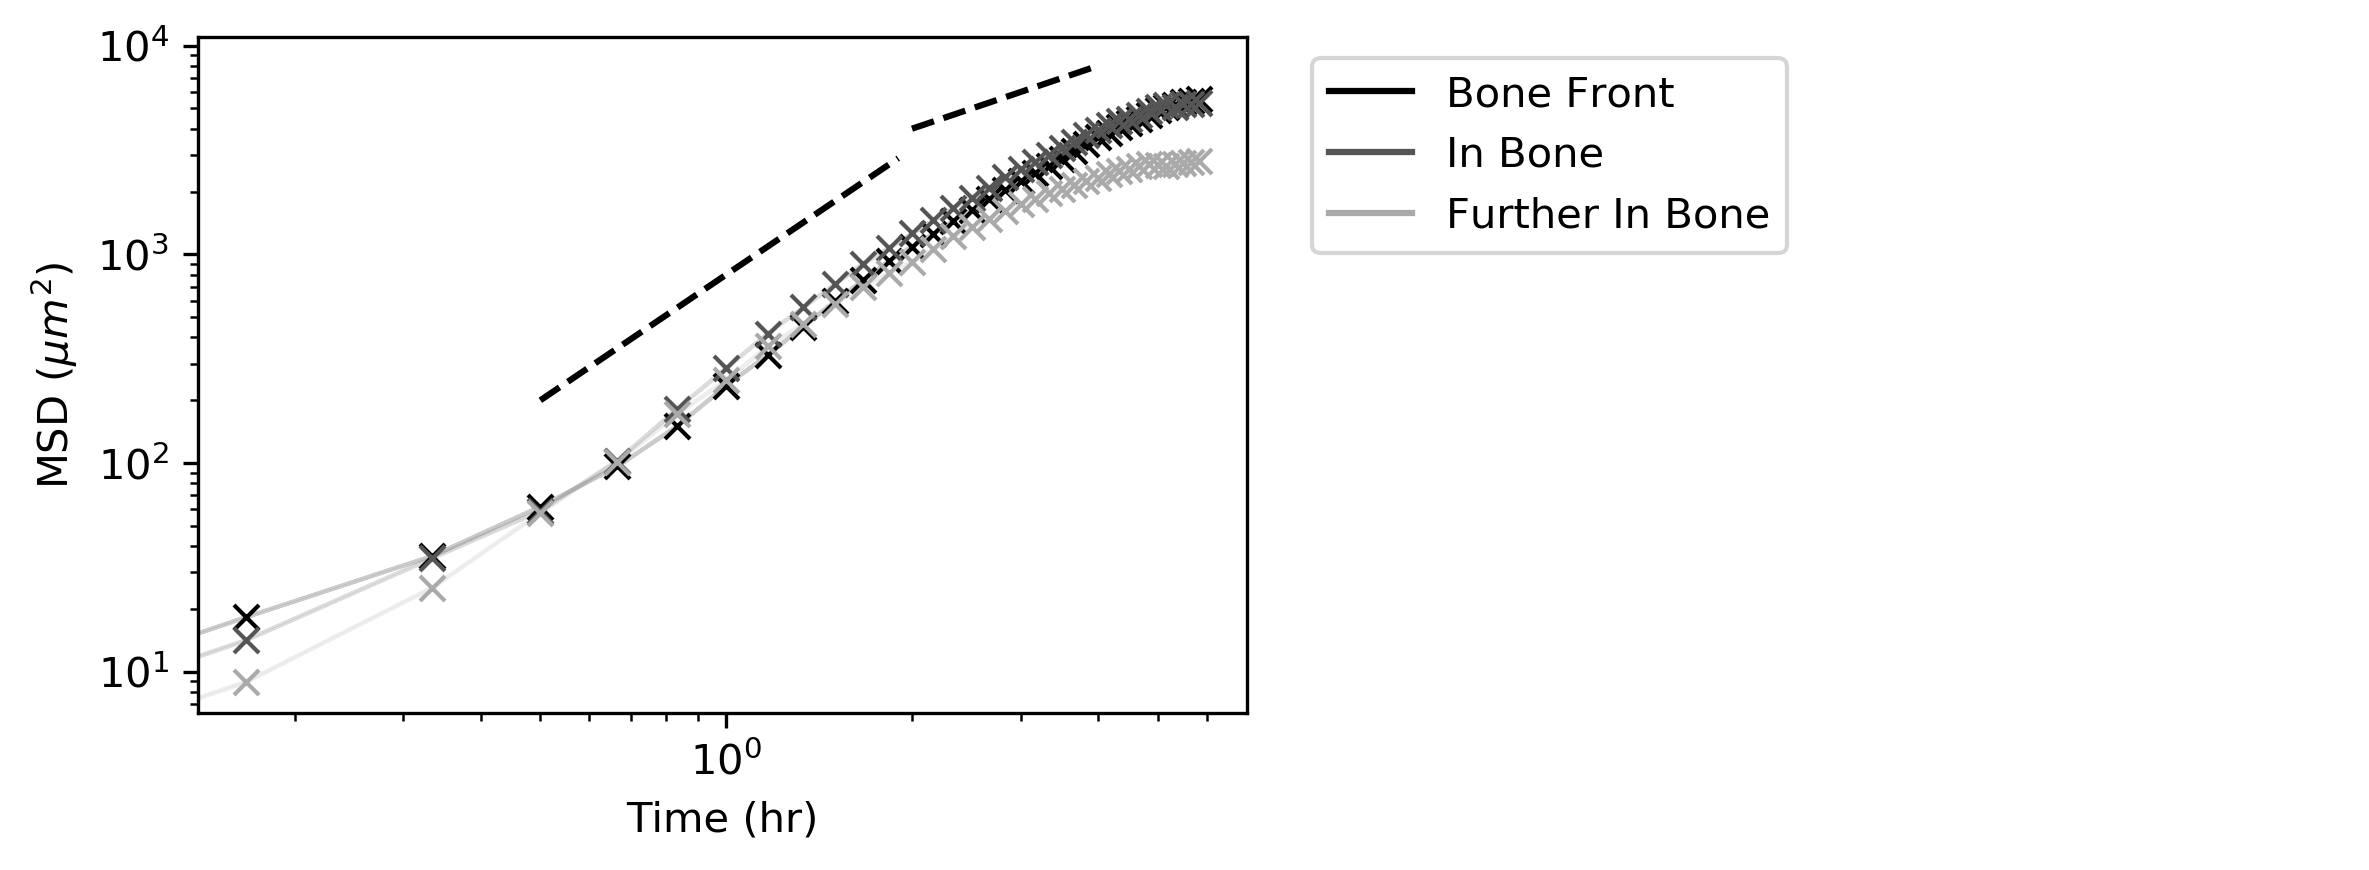

In [97]:
# Plot displacements in horizontal direction vs t
fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

pix_per_micron = pix_per_micron_all[i1];
slices = slices_all_all[0][0][0, slice_range];

for i2 in range(N_files_per_video):
    MSD_avg_all_all = np.mean( np.array(MSD_avg_all)[:, i2], axis=0 ) # works only if MSD_avg_all has regular sizes!
    sem_all_all_all = np.sqrt( np.sum( np.array(sem_all_all)[:, i2]**2, axis=0 )/N_videos );
    RMSD_avg_all_all = np.sqrt(MSD_avg_all_all)
    
    # plot MSD
    axs[0].plot(slices, MSD_avg_all_all, 'x', label=names_compare[i2], color=colors_cats[i2]); # def_colors / colors_cats
    axs[0].fill_between(slices, MSD_avg_all_all-sem_all_all_all, MSD_avg_all_all+sem_all_all_all, alpha=0.2, color=colors_cats[i2])
    axs[0].set( xlabel='Time (hr)', ylabel='MSD ($\\mu m^2$)'  )

    # plot RMSD
    # axs[0].plot(slices, RMSD_avg_all_all, label=names_compare[i2], color=colors_cats[i2]); # def_colors / colors_cats
    # axs[0].fill_between(slices, RMSD_avg_all_all-sem_all_all_all, RMSD_avg_all_all+sem_all_all_all, alpha=0.2, color=colors_cats[i2])
    # axs[0].set( xlabel='Time (hr)', ylabel='RMSD ($\\mu m$)'  )
    
    # Set scale
    axs[0].set( xscale='log', yscale='log' )
    #axs[0].set( yscale='log' ) 
    #axs[0].set( xlim = [0, 1] );
    
    # slopes
    t1 = 1;
    t2 = 3;
    v = (np.sqrt(MSD_avg_all_all[int(t2*6)]) - np.sqrt(MSD_avg_all_all[int(t1*6)]))/(t2-t1);
    print("{}, v={} microns/hr".format(names_compare[i2], v) )

# plot lines with scaling
t1_plot = np.arange(0.5, 2, 0.1);
y1_plot = 800*t1_plot**2;
t2_plot = np.arange(2, 4, 0.1);
y2_plot = 2000*t2_plot;
axs[0].plot(t1_plot, y1_plot, 'k--')
axs[0].plot(t2_plot, y2_plot, 'k--')

#plt.figure(dpi=100, figsize = (2, 1) )
for i, this_label in enumerate(names_compare):
    axs[1].plot(np.nan, label=this_label, color=colors_cats[i])
axs[1].legend(loc='upper left')
axs[1].axis('off')
     
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()

plt.show()

#### Calculate average velocities

In [481]:
t_lims = np.array([0, 4*6]);
avg_velocities = np.zeros([N_videos, N_files_per_video]);

# calculate velocities
avg_velocities = np.array([ [ (np.diff(np.sqrt(MSD_avg_all[i1][i2][t_lims]))/np.diff(t_lims/6)).flat[0]  for i2 in range(N_files_per_video)] for i1 in range(N_videos)])

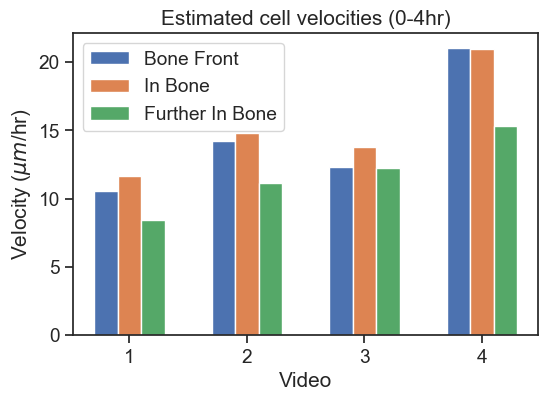

In [482]:
# plot results
width = 0.2;  # the width of the bars

x = np.arange(N_videos) - (N_files_per_video-1)*width/2 + 1;  # the label locations

plt.figure(dpi=100);
for i2 in range(N_files_per_video):
    plt.bar(x + i2*width*(N_files_per_video-1)/2, avg_velocities[:, i2], width, label=names_compare[i2])
plt.legend();
plt.xticks(np.arange(N_videos)+1)
plt.xlabel('Video')
plt.ylabel('Velocity ($\mu m$/hr)')
plt.title('Estimated cell velocities (0-4hr)')
plt.show();

# (2) Persistence of cell motion

Do cells in the front move more persistently (i.e. along the same direction) than cells in the bulk?

### Approach 1: "Fraction of efficient movement"
Define persistence as the ratio between the net displacement (i.e. distance between initial and final position of a cell) and the total displacement (i.e. total length of path travelled). 
This is related to but different from the approach in <a href = "https://www.nature.com/articles/ncb1762#Sec27"> Simpson et al., 2008 </a>.

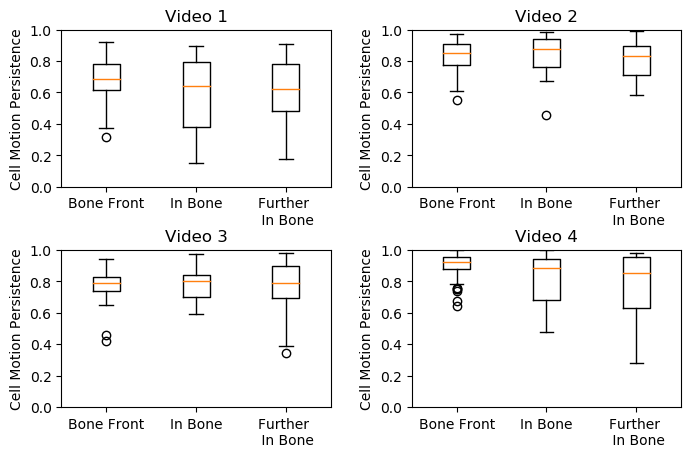

In [362]:
persistences_all_all = np.array([[None]*N_files_per_video for _ in range(N_videos)]);
labels_all = np.array([[None]*N_files_per_video for _ in range(N_videos)]);

pers_df = pd.DataFrame(columns=['Video', 'Location', 'Persistence']); # store as dataframe
counter = 0;

names_compare_2 = ["Bone Front", "In Bone", "Further \n In Bone"];

fig, axs = plt.subplots(2, 2, figsize=(8, 5), dpi=100)

for i1 in range(N_videos):
    [ix, iy] = divmod(i1, 2)
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2];
        Y_all = Y_all_all[i1][i2];
        N_cells = N_cells_all[i1][i2];

        # calculate total displacement
        del_X_all = np.array(list(map(np.diff, X_all))); # X[t+1]-X[t] for all cells
        del_Y_all = np.array(list(map(np.diff, Y_all))); # Y[t+1]-Y[t] for all cells
        displacements_all = np.nansum( np.sqrt(del_X_all**2 + del_Y_all**2) , axis=1 );

        # calculate net displacement
        net_displacements_all = np.zeros(N_cells);
        for i in range(N_cells):
            X_t = X_all[i, :]; 
            Y_t = Y_all[i, :];
            dX = X_t[~np.isnan(X_t)][-1]-X_t[~np.isnan(X_t)][0]; # X(t_final) - X(t_initial)
            dY = Y_t[~np.isnan(Y_t)][-1]-Y_t[~np.isnan(Y_t)][0]; # Y(t_final) - Y(t_initial)
            net_displacements_all[i] = np.sqrt(dX**2 + dY**2);

        data_out = net_displacements_all/displacements_all;
        persistences_all_all[i1][i2] = data_out;
        labels_all[i1][i2] = '{}'.format(names_compare_2[i2]);
        
        for i3 in range( len(data_out)  ):
            pers_df.loc[counter] = [i1+1, names_compare[i2], data_out[i3]];
            counter += 1;
                
    # Plot figure
    axs[ix, iy].boxplot(persistences_all_all[i1,:], labels=labels_all[i1,:]);   
    axs[ix, iy].set(ylim=[0,1], title='Video {}'.format(i1+1) ); 
    axs[ix, iy].set(ylabel='Cell Motion Persistence');

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show();

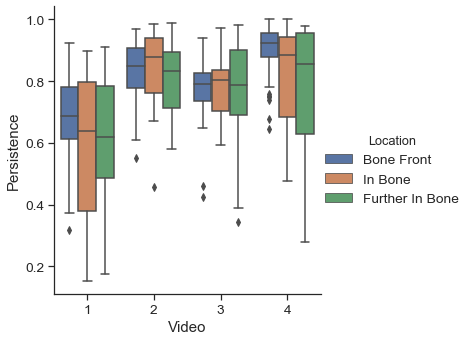

In [422]:
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook", font_scale=1.25)

# -- plot data only --
#h_plot = sns.catplot(x="Location", y="Persistence", hue="Video", data=pers_df);
#h_plot = sns.catplot(x="Location", y="Persistence", hue="Video", kind="swarm", data=pers_df);

# facet grid 
#fig, axs = plt.subplots(ncols=4)
#h_plot = sns.catplot(x="Location", y="Persistence", col="Video", data=pers_df);
#sns.catplot(x="Location", y="Persistence", kind="swarm", data=data_plot, ax=g.axes[i]);

# -- plot statistics --
# box plot
#h_plot = sns.catplot(x="Location", y="Persistence", kind="box", hue="Video", data=pers_df);
h_plot = sns.catplot(x="Video", y="Persistence", kind="box", hue="Location", data=pers_df);
# violin plot
#h_plot =  sns.catplot(x="Location", y="Persistence", kind="violin", inner=None, data=pers_df, ax=g.ax);
# bar plot (mean values)
#h_plot = sns.catplot(x="Location", y="Persistence", hue="Video", kind="bar", data=pers_df);

#### Average over experiments

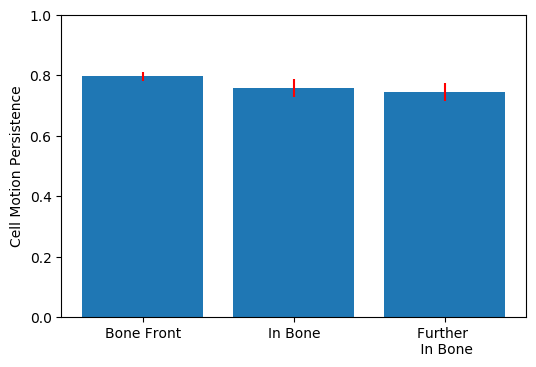

In [141]:
persistences_mean_all = np.mean([[np.mean(persistences_all_all[i1][i2]) for i1 in range(N_videos)] for i2 in range(N_files_per_video)], axis=1)
persistences_var_avg_all = [[np.var(persistences_all_all[i1][i2])/N_cells_all[i1][i2] for i1 in range(N_videos)] for i2 in range(N_files_per_video)]
persistences_sem_all = np.sqrt( np.array(list(map(np.sum, persistences_var_avg_all)))/N_videos );

fig, ax = plt.subplots(dpi=100)
plt.bar( np.arange(N_files_per_video), persistences_mean_all )
plt.errorbar( np.arange(N_files_per_video), persistences_mean_all, persistences_sem_all, fmt = ' ', color='r')
plt.ylim((0,1))
#plt.xticks([0, 1, 2])
ax.set_ylabel('Cell Motion Persistence')
ax.set_xticks( np.arange(N_files_per_video) )
ax.set_xticklabels(names_compare_2)

plt.show();

#### Statistical analysis on persistence results
Check for statistical significance between groups

In [379]:
from scipy import stats
import statsmodels as sm
from statsmodels.formula.api import ols

In [377]:
# ANOVA test 
for i1 in range(N_videos):
    # use np array
    test_res = stats.f_oneway(*persistences_all_all[i1]);
    print("Video {}:".format(i1+1), test_res)
    
    # use dataframe
    conds = [(pers_df['Video'] == i1+1) & (pers_df['Location'] == names_compare[i]) for i in range(N_files_per_video)];
    test_res2 = stats.f_oneway(pers_df['Persistence'][conds[0]], 
             pers_df['Persistence'][conds[1]],
             pers_df['Persistence'][conds[2]])
    #print("Video {}:".format(i1+1), test_res2);
    

Video 1: F_onewayResult(statistic=2.099082195990601, pvalue=0.1278324882855615)
Video 2: F_onewayResult(statistic=0.7301596964111163, pvalue=0.4841735715273566)
Video 3: F_onewayResult(statistic=0.007590934377936113, pvalue=0.9924383145494482)
Video 4: F_onewayResult(statistic=8.104341442547424, pvalue=0.00049955942719223)


In [301]:
# Pairwise t-tests
t_stat_all = np.zeros([N_videos, N_files_per_video, N_files_per_video])
p_vals_all = np.zeros([N_videos, N_files_per_video, N_files_per_video])
for i1 in range(N_videos):
    for i2 in range(N_files_per_video):
        for i3 in range(i2):
            t_stat_all[i1, i2, i3] = stats.ttest_ind( persistences_all_all[i1][i2], persistences_all_all[i1][i3], axis=0 ).statistic;
            p_vals_all[i1, i2, i3] = stats.ttest_ind( persistences_all_all[i1][i2], persistences_all_all[i1][i3], axis=0 ).pvalue;
            print("Video {}, {} and {}: \n t-statistic = {} \n p value = {}".format(i1+1, names_compare[i2], names_compare[i3], t_stat_all[i1, i2, i3].round(4), p_vals_all[i1, i2, i3].round(4) ))

Video 1, In Bone and Bone Front: 
 t-statistic = -1.9679 
 p value = 0.0532
Video 1, Further In Bone and Bone Front: 
 t-statistic = -1.4984 
 p value = 0.138
Video 1, Further In Bone and In Bone: 
 t-statistic = 0.6494 
 p value = 0.5187
Video 2, In Bone and Bone Front: 
 t-statistic = 0.3855 
 p value = 0.701
Video 2, Further In Bone and Bone Front: 
 t-statistic = -0.9348 
 p value = 0.3527
Video 2, Further In Bone and In Bone: 
 t-statistic = -1.0899 
 p value = 0.2799
Video 3, In Bone and Bone Front: 
 t-statistic = 0.1224 
 p value = 0.9029
Video 3, Further In Bone and Bone Front: 
 t-statistic = -0.0341 
 p value = 0.9729
Video 3, Further In Bone and In Bone: 
 t-statistic = -0.1028 
 p value = 0.9184
Video 4, In Bone and Bone Front: 
 t-statistic = -3.2649 
 p value = 0.0015
Video 4, Further In Bone and Bone Front: 
 t-statistic = -3.9063 
 p value = 0.0002
Video 4, Further In Bone and In Bone: 
 t-statistic = -1.1364 
 p value = 0.2598


In [387]:
# ANOVA as linear regression
video = 2;
df = pers_df[pers_df['Video'] == video];
results = ols('Persistence ~ C(Location)', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Persistence   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7302
Date:                Fri, 24 Apr 2020   Prob (F-statistic):              0.484
Time:                        16:33:11   Log-Likelihood:                 92.203
No. Observations:                 112   AIC:                            -178.4
Df Residuals:                     109   BIC:                            -170.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.8329      0.016     53.029      0.000       0.802       0.864
C(Location)[T.Further In Bone]    -0.0216      0.024     -0.891      0.375      -0.070       0.026
C(Location)[T.In Bone]             0.0095      0.025      0.382      0.703      -0.040       0.059
==============================================================================
Omnibus:                       13.247   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.221
Skew:                          -0.842   Prob(JB):                     0.000817
Kurtosis:                       3.459   Cond. No.                         3.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [392]:
# --- Check ANOVA assumptions ---
for i1 in range(N_videos):
    # (1) Check whether residuals are normally distributed
    df = pers_df[pers_df['Video'] == i1+1];
    results = ols('Persistence ~ C(Location)', data=df).fit()
    test_res = stats.shapiro(results.resid)
    print("Residuals normally distributed? \n Video {}:".format(i1+1), test_res)
    
    # (2) Check whether variances are equal    
    test_res2 = stats.levene(*persistences_all_all[i1]);
    print("Equal variances? \n Video {}:".format(i1+1), test_res2)
    
    # (3) Responses for a given group are independent and identically distributed normal random variables
    # Probably not met, as cells are not independent of each other

Residuals normally distributed? 
 Video 1: (0.976473867893219, 0.058497946709394455)
Equal variances? 
 Video 1: LeveneResult(statistic=6.729448407716044, pvalue=0.0017980889685051986)
Residuals normally distributed? 
 Video 2: (0.9398440718650818, 7.54801876610145e-05)
Equal variances? 
 Video 2: LeveneResult(statistic=0.37293252082025613, pvalue=0.6895870348562658)
Residuals normally distributed? 
 Video 3: (0.926095724105835, 8.359135790669825e-06)
Equal variances? 
 Video 3: LeveneResult(statistic=5.44001219821313, pvalue=0.005562334348373582)
Residuals normally distributed? 
 Video 4: (0.9174150228500366, 1.3207392157710274e-06)
Equal variances? 
 Video 4: LeveneResult(statistic=13.851454166843506, pvalue=3.86840514648975e-06)


### Approach 2: velocity correlation functions
The velocity autocorrelation function shows how cells maintain their velocity (speed and directionality) over time. The plots show the correlation between a specified initial time (e.g. t=0 hours) and all further times. The decay shows how well cells maintain their velocities over time. <br>
We normalize the velocities so that in the final plots we compare only directionality and not speed at different times.

<u>Technical notes</u> <br>
The velocity autocorrelation function is defined as $C_{VV}(t, t') = \langle v(t) v(t') \rangle$, 
where $\langle \ldots \rangle$ is an ensemble-average over all cells. <br>
Under time-invariance, $C_{VV}(t, t')$ would be a function of $|t-t'|$ only. However, for our system we expect the correlation to depend on both $t$ and $t'$, so choosing an apprioriate initial time to compare with is critical. 
Recall that $C_{VV}(t, t')$ decays exponentially for Brownian motion. <br>
Note that $C_{VV}(t, t')$ is unnormalized, but can be normalized to give Pearson correlation coefficients. We normalize by dividing all velocities by their norm, so that $|v(t)| = 1$ for all $t$.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


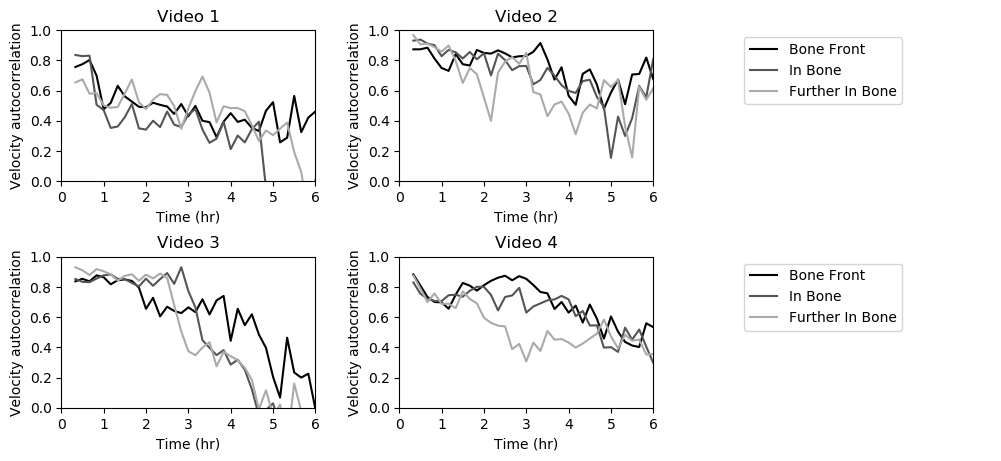

All velocities are relative to the "initial" velocity at time = 0.333 hrs


In [27]:
normalize = 1; # Normalize velocities?
t_init = 2; # initial time to correlate with
t_range = np.arange(len(slice_range))+t_init; # time range to plot 

#fig, axs = plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)
velocities_all_all = [[None]*N_files_per_video for _ in range(N_videos)];
fig, axs = plt.subplots(2, 3, figsize=(12, 5), dpi=100);

for i1 in range(N_videos):
    [ix, iy] = divmod(i1, 2); # positions of plots
    pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2];
        Y_all = Y_all_all[i1][i2];
        N_cells = N_cells_all[i1][i2];
        N_slices = N_slices_all[i1][i2];
        slices_all = slices_all_all[i1][i2];
        
        # calculate velocities
        del_X_all = np.array(list(map(np.diff, X_all))); # X[t+1]-X[t] for all cells
        del_Y_all = np.array(list(map(np.diff, Y_all))); # Y[t+1]-Y[t] for all cells
        velocities_all = np.swapaxes( np.swapaxes( np.array([del_X_all, del_Y_all])/pix_per_micron, 0, 1), 1, 2); # units: microns
        velocities_all_all[i1][i2] = velocities_all; # store for later use
        
        # calculate autocorrelation        
        correlations_all = np.zeros([N_cells, N_slices-t_init-1])*np.nan;
        for i_cell in range(velocities_all.shape[0]):  
            v_temp = velocities_all[i_cell]; # no normalization
            if normalize:
                norm = np.array(list(map(np.linalg.norm, v_temp))).reshape(len(v_temp), 1);
                v_temp = velocities_all[i_cell]/norm; # normalized velocities
            correlations_all[i_cell, :] = np.dot(v_temp[t_init:], v_temp[t_init]); # normalized
            
        correlation_func = np.nanmean(correlations_all, axis=0);
        
        axs[ix, iy].plot(slices_all[0, t_range], correlation_func[t_range], color=colors_cats[i2])
        #this_title = 'Video {} ({}) {}, {} cells'.format(i1+1, video_labels[i1], names_compare[i2], str(N_cells));
        this_title = 'Video {}'.format(i1+1);
        axs[ix, iy].set(xlabel='Time (hr)', ylabel='Velocity autocorrelation', title=this_title);
        axs[ix, iy].set(xlim=[t_lower, t_upper], ylim=[0,1])
        #axs[ix, iy].set(yscale = 'log')

plt.subplots_adjust(hspace=0.5, wspace=0.33)

# ---- Legend ----
for row in range(2):
    for i, this_label in enumerate(names_compare):
        axs[row, 2].plot(np.nan, label=this_label, color=colors_cats[i])
    axs[row, 2].legend(loc='upper left')
    axs[row, 2].axis('off')
plt.show()

print('All velocities are relative to the "initial" velocity at time = {} hrs'.format(round(t_init/6, 3)))

# (3) Spatial correlations
How do correlations between cell motions depend on the spatial locations and distances between cells? <br>

### Spatial velocity correlations
Define $C_{VV}(x_i, x_j) = \langle v(x_i, t)\, v(x_j, t) \rangle$ as the spatial correlation function of cell velocities. Assume $C_{VV}(x_i, x_j) = C_{VV}(x_i-x_j)$ and average over cells with the same distance (in practice, bin together pairs of cells that have similar distance to each other). 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice


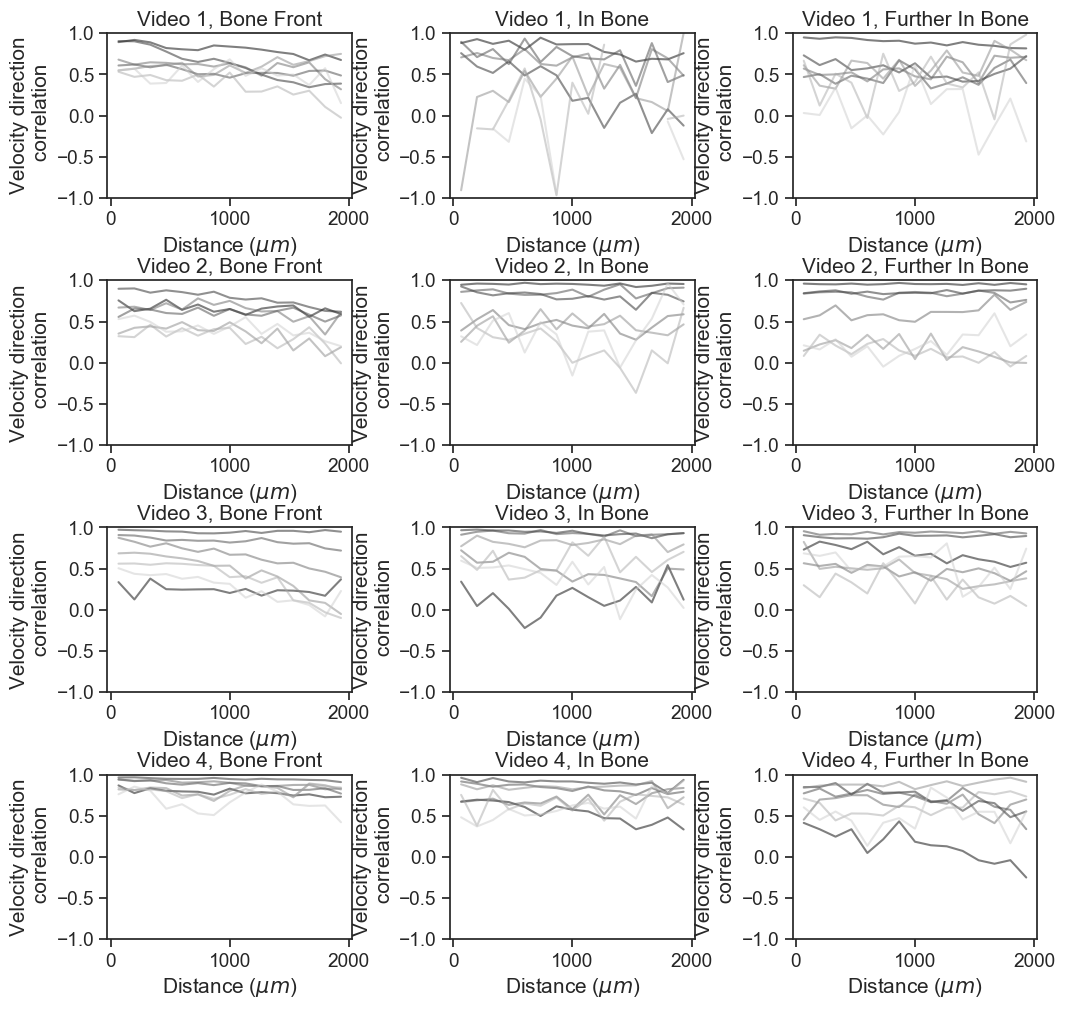

Lighter colors = later times


In [425]:
nbins = 15;
edges = np.linspace(0, 2000, nbins+1)
#t_selected = np.arange(0, N_slices_all[i1][i2]-1, 6) # <--- adjust plotted times
t_selected = np.array([0, 1, 2, 3, 4, 5, 6])*6; #np.arange(0, N_slices_all[i1][i2]-1, 6) 
normalize = 1;
ylabel_extra='';
if normalize:
    ylabel_extra = "direction"
    
corr_v_all_all = np.zeros([N_videos, N_files_per_video, len(t_selected), nbins]);

fig, axs = plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)
for i1 in range(N_videos):
    #[ix, iy] = divmod(i1, 2); # positions of plots
    #pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        t_idx=0;
        for t in t_selected:
            X_all = X_all_all[i1][i2][:, t];
            Y_all = Y_all_all[i1][i2][:, t];

            # filter out cells which are not tracked
            if t<N_slices_all[i1][i2]:
                cell_filter = ~np.isnan( X_all_all[i1][i2][:, t+1] ); # cell posiiton still defined the next time step
            else:
                cell_filter = ~np.isnan( X_all_all[i1][i2][:, t] );
            X_all = X_all[cell_filter];
            Y_all = Y_all[cell_filter];

            # pairwise distances between cells
            incl_self = 0; # include self-pairs of the form [i,i]?

            # calculate pairwise distances
            X_all_paired = np.array([ [X_all[i], X_all[j]] for i in range(len(X_all)) for j in range(i+incl_self)]); # loop j over range(i+1) to include self-pairs, or range(i) to exclude self-pairs
            Y_all_paired = np.array([ [Y_all[i], Y_all[j]] for i in range(len(Y_all)) for j in range(i+incl_self)]);
            def f(x, y):
                return np.sqrt((x[0]-x[1])**2 + (y[0]-y[1])**2)
            pairwise_dist_all = np.array(list(map(f, X_all_paired, Y_all_paired )) );

            # retrieve velocities
            this_velocities_all = velocities_all_all[i1][i2][cell_filter, t, :];

            # linear to pair indices
            pair_idx = np.array([ [i, j] for i in range(len(X_all)) for j in range(i+incl_self)]); 

            # define bin edges, bin weights
            # everything that falls outside of the edges of the pre-defined bins is neglected
            hist_data, edges = np.histogram(pairwise_dist_all, bins = edges);
            compare_bin_edges = np.array([pairwise_dist_all[i] <= edges for i in range(len(pairwise_dist_all))]);
            bin_idx = np.array(list(map( np.argmax, compare_bin_edges))); # indices of the bins of all the data

            # calculate correlations
            corr_v_all = np.zeros(len(edges)-1); # correlation function
            temp_sum = [];
            for i in range(1, len(edges)):
                bin_i_idx = np.argwhere(bin_idx==i).flatten(); # linear indices that fall in bin i
                temp_sum.append(len(bin_i_idx));
                bin_i_pair_idx = pair_idx[bin_i_idx]; # pair indices that fall in bin i
                this_corr_v = np.zeros( len(bin_i_pair_idx) );
                for j in range(len(bin_i_pair_idx)):
                    cell_1=bin_i_pair_idx[j][0]
                    cell_2=bin_i_pair_idx[j][1]
                    v1 = this_velocities_all[cell_1];
                    v2 = this_velocities_all[cell_2];
                    #corr_v_all[i] += np.inner(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2); 
                    corr_temp = np.inner(v1, v2);
                    if normalize and np.linalg.norm(v1)!=0 and np.linalg.norm(v2)!=0:
                        corr_temp = corr_temp/np.linalg.norm(v1)/np.linalg.norm(v2);  
                    this_corr_v[j] = corr_temp;
                #corr_v_all[i] = corr_v_all[i]/len(bin_i_pair_idx);
                corr_v_all[i-1] = np.nanmean(this_corr_v);

            # plot results
            bincenters = (edges[1:]+edges[:-1])/2;
            #axs[i1, i2].plot(bincenters, corr_v_all, alpha=0.5);
            axs[i1, i2].plot(bincenters, corr_v_all, color=np.ones(3)*0.8*(t/t_selected[-1]), alpha=0.5)
            
            # store all results
            corr_v_all_all[i1, i2, t_idx, :] = corr_v_all;
            t_idx += 1;
            
        this_title = 'Video {}, {}'.format(i1+1, names_compare[i2]);
        axs[i1, i2].set(title=this_title, xlabel = 'Distance ($\mu m$)', ylabel = 'Velocity {}\n correlation'.format(ylabel_extra))
        if normalize:
            axs[i1, i2].set(ylim = (-1, 1))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.show()
print( "Lighter colors = later times" )

# Display legend
# axs[1].plot(np.nan, label='t={}'.format(t/6));
# axs[1].legend(loc='upper left')
# axs[1].set(xticks=[], yticks=[]);
# axs[1].axis('off')
# plt.xlabel('Distance ($\mu m$)')
# plt.ylabel('Velocity correlation')
# plt.ylim([-1, 1])

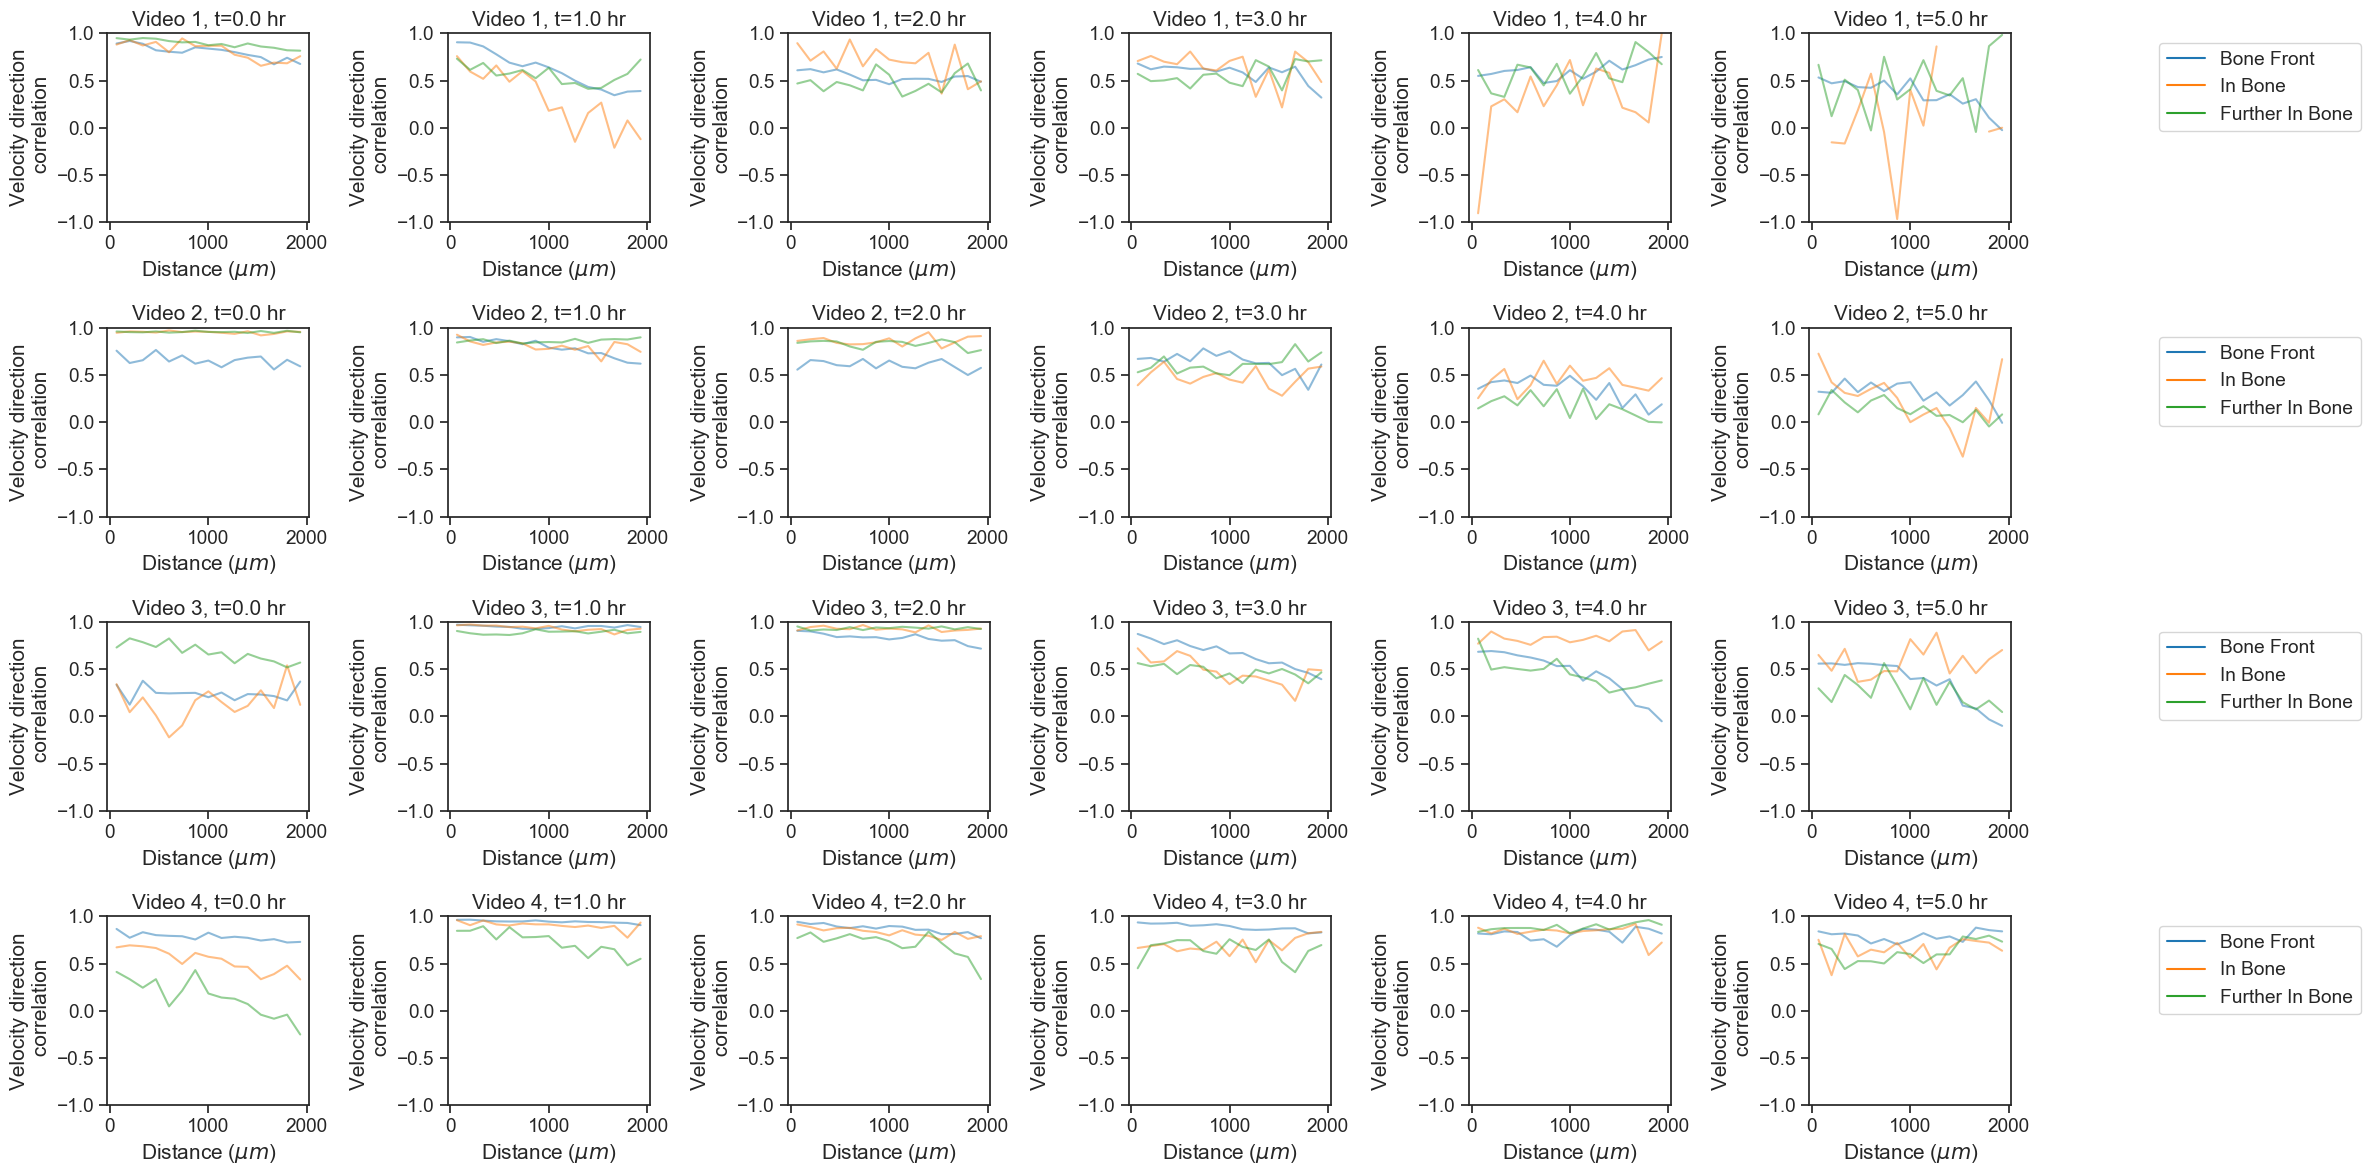

In [431]:
# t_idx_selected = np.arange(len(t_selected)-1); #np.array([0, 2, 4, 6])*6; #np.arange(0, N_slices_all[i1][i2]-1, 6) 

fig, axs = plt.subplots(N_videos, len(t_idx_selected)+1, figsize=(4*len(t_idx_selected), 3*N_videos), dpi=100)

for i1 in range(N_videos):
    #[ix, iy] = divmod(i1, 2); # positions of plots
    #pix_per_micron = pix_per_micron_all[i1];
    for t_idx in range(len(t_idx_selected)):
        t = t_selected[t_idx];
        for i2 in range(N_files_per_video):
            corr_v_all = corr_v_all_all[i1, i2, t_idx, :];
            
            # plot results
            bincenters = (edges[1:]+edges[:-1])/2;
            #axs[i1, i2].plot(bincenters, corr_v_all, alpha=0.5);
            axs[i1, t_idx].plot(bincenters, corr_v_all, color=def_colors[i2], alpha=0.5)
            
        this_title = 'Video {}, t={} hr'.format(i1+1, t/6);
        axs[i1, t_idx].set(title=this_title, xlabel = 'Distance ($\mu m$)', ylabel = 'Velocity {}\n correlation'.format(ylabel_extra))
        if normalize:
            axs[i1, t_idx].set_ylim( (-1, 1) )

# ---- Legend ----
for row in range(N_videos):
    for i, this_label in enumerate(names_compare):
        axs[row, t_idx+1].plot(np.nan, label=this_label, color=def_colors[i])
    axs[row, t_idx+1].legend(loc='upper left')
    axs[row, t_idx+1].axis('off')

plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.tight_layout()

plt.show()

<b>Conclusion</b>: no significant spatial dependence of velocity correlations. Generally, cells far away from each other are just as likely to move in the same direction as cells close to each other.

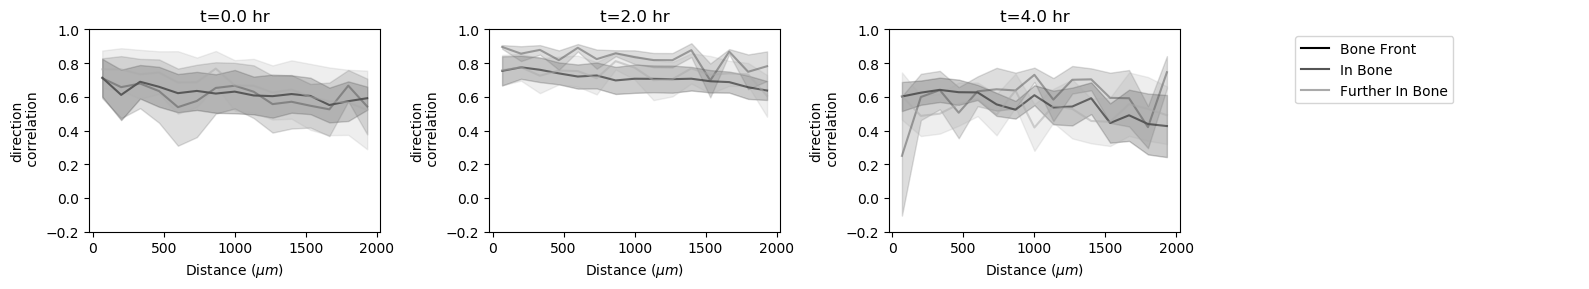

In [176]:
t_idx_selected = np.arange(len(t_selected)-1); #np.array([0, 2, 4, 6])*6; #np.arange(0, N_slices_all[i1][i2]-1, 6) 
video_sel = [0, 1, 2, 3];

fig, axs = plt.subplots(1, len(t_idx_selected)+1, figsize=(16, 3), dpi=100)

for t_idx in range(len(t_idx_selected)):
    t = t_selected[t_idx];
    for i2 in range(N_files_per_video):
        corr_v_all_avg = np.mean( corr_v_all_all[:, i2, t_idx, :], axis=0 )
        corr_v_all_sem = np.std( corr_v_all_all[:, i2, t_idx, :], axis=0 )/np.sqrt(N_videos);
        
        # plot results
        bincenters = (edges[1:]+edges[:-1])/2;
        #axs[i1, i2].plot(bincenters, corr_v_all, alpha=0.5);
        axs[t_idx].plot(bincenters, corr_v_all_avg, color=colors_cats[i2], alpha=0.5)
        axs[t_idx].fill_between(bincenters, corr_v_all_avg-corr_v_all_sem, corr_v_all_avg+corr_v_all_sem, color=colors_cats[i2], alpha=0.2)

    this_title = 't={} hr'.format(t/6);
    axs[t_idx].set(title=this_title, xlabel = 'Distance ($\mu m$)', ylabel = '{}\n correlation'.format(ylabel_extra));
    if normalize:
        axs[t_idx].set_ylim( (-0.2, 1) )

# ---- Legend ----
for i, this_label in enumerate(names_compare):
    axs[len(t_idx_selected)].plot(np.nan, label=this_label, color=colors_cats[i])
axs[len(t_idx_selected)].legend(loc='upper left')
axs[len(t_idx_selected)].axis('off')
        
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.tight_layout()

plt.show()

### Check that the number of pairs of cells in each of the bins is roughly equal
(or at least, that there are no bins which have very few cells)

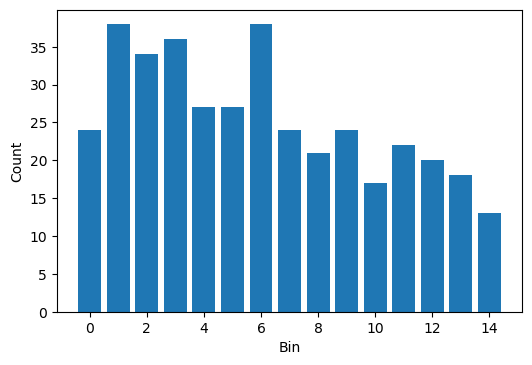

In [20]:
t = 0;
#------------ Recompute bins ------------------ 
X_all = X_all_all[i1][i2][:, t]; Y_all = Y_all_all[i1][i2][:, t];
if t<N_slices_all[i1][i2]:
    cell_filter = ~np.isnan( X_all_all[i1][i2][:, t+1] ); # cell posiiton still defined the next time step
else:
    cell_filter = ~np.isnan( X_all_all[i1][i2][:, t] );
X_all = X_all[cell_filter]; Y_all = Y_all[cell_filter];
X_all_paired = np.array([ [X_all[i], X_all[j]] for i in range(len(X_all)) for j in range(i+incl_self)]); # loop j over range(i+1) to include self-pairs, or range(i) to exclude self-pairs
Y_all_paired = np.array([ [Y_all[i], Y_all[j]] for i in range(len(Y_all)) for j in range(i+incl_self)]);
def f(x, y):
    return np.sqrt((x[0]-x[1])**2 + (y[0]-y[1])**2)
pairwise_dist_all = np.array(list(map(f, X_all_paired, Y_all_paired )) );
this_velocities_all = velocities_all_all[i1][i2][cell_filter, t, :];
pair_idx = np.array([ [i, j] for i in range(len(X_all)) for j in range(i+incl_self)]); 
hist_data, edges = np.histogram(pairwise_dist_all, bins = edges);
#----------------------------------------------

plt.figure(dpi=100);
bincenters = (edges[1:]+edges[:-1])/2
plt.bar(range(len(hist_data)), hist_data)
#plt.plot([0, 900], 20*np.ones(2), 'r--')
plt.xlabel('Bin')
plt.ylabel('Count')
plt.show()

In [21]:
# --- Troubleshoot ---
print( hist_data )
print( temp_sum )
print(np.sum(bin_idx==0) )
#print( np.argwhere( np.array(list(map( np.argmax, compare_bin_edges))) == 0 ) )
this_bin = 2;
print( pairwise_dist_all[this_bin] )
print( compare_bin_edges[this_bin] )
print( pair_idx[this_bin] )
# print( X_all_all[i1][i2][10, t], X_all_all[i1][i2][5, t] )
# print( Y_all_all[i1][i2][10, t], Y_all_all[i1][i2][5, t] )

[24 38 34 36 27 27 38 24 21 24 17 22 20 18 13]
[11, 23, 14, 18, 13, 19, 13, 9, 10, 10, 5, 10, 9, 3, 3]
20
80.23091673413684
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[2 1]


### Pairwise distance statistics

Before plotting the correlation functions, we should examine the distribution of all pairwise distances of the tracked cells. <br>

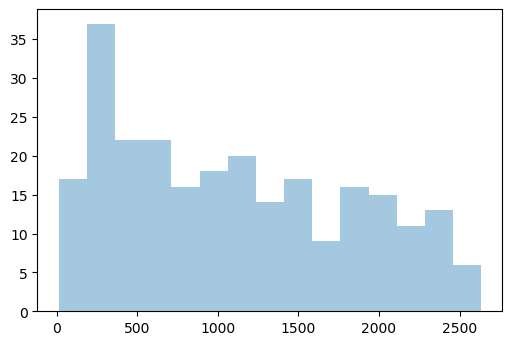

In [22]:
# --- Plot for one snapshot ---
i1=0;
i2=1;
t=2;

X_all = X_all_all[i1][i2][:, t];
Y_all = Y_all_all[i1][i2][:, t];
# pairwise distances between cells
incl_self = 0; # include self-pairs of the form [i,i]?
# loop j over range(i+1) to include self-pairs, or range(i) to exclude self-pairs
X_all_paired = np.array([ [X_all[i], X_all[j]] for i in range(len(X_all)) for j in range(i+incl_self)]);
Y_all_paired = np.array([ [Y_all[i], Y_all[j]] for i in range(len(X_all)) for j in range(i+incl_self)]);
def f(x, y):
    return np.sqrt((x[0]-x[1])**2 + (y[0]-y[1])**2)
pairwise_dist_all = np.array(list(map(f, X_all_paired, Y_all_paired )) );

# -- Verify that this yields the pair-wise elements of an array --
# data_all = np.array([[i, j] for i in range(10) for j in range(i+1)]).T;
# plt.scatter( data_all[0], data_all[1]  )
plt.figure(dpi=100)
plt.hist(pairwise_dist_all, bins=15, alpha = 0.4)
plt.show()

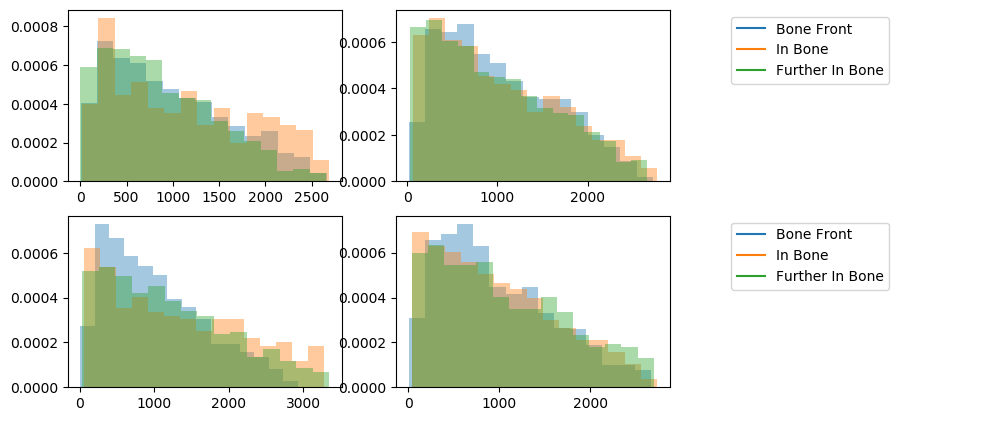

In [23]:
# --- plot for all results ---
t=0;
incl_self = 0; # include self?

pairwise_dist_all_all = [[None]*N_files_per_video for _ in range(N_videos)];
fig, axs = plt.subplots(2, 3, figsize=(12, 5), dpi=100)
for i1 in range(N_videos):
    [ix, iy] = divmod(i1, 2)
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2][:, t];
        Y_all = Y_all_all[i1][i2][:, t];
        # pairwise distances between cells
        incl_self = 0; # include self-pairs of the form [i,i]?
        # loop j over range(i+1) to include self-pairs, or range(i) to exclude self-pairs
        X_all_paired = np.array([ [X_all[i], X_all[j]] for i in range(len(X_all)) for j in range(i+incl_self)]);
        Y_all_paired = np.array([ [Y_all[i], Y_all[j]] for i in range(len(Y_all)) for j in range(i+incl_self)]);
        def f(x, y):
            return np.sqrt((x[0]-x[1])**2 + (y[0]-y[1])**2)
        pairwise_dist_all = np.array(list(map(f, X_all_paired, Y_all_paired )) );
        
        # store for later use
        pairwise_dist_all_all[i1][i2] = pairwise_dist_all; 
        
        # plot histogram
        axs[ix, iy].hist(pairwise_dist_all, bins=15, alpha = 0.4, density=True)
        
# --- legend ---
for row in range(2):
    for i, this_label in enumerate(names_compare):
        axs[row, 2].plot(np.nan, label=this_label)
    axs[row, 2].legend(loc='upper left')
    axs[row, 2].axis('off')

## (4) Horizontal displacements
Shows displacement of cells relative to their initial position in the direction perpendicular to the front (horizontal). However, cells do not necessarily migrate exactly in the horizontal direction due to two factors: (1) the orientation of the front in the image is never perfectly vertical, (2) individual cells drift also in the direction perpendicular to the front. A better metric for cell motility is therefore the MSD. <br>
<a style="color:red;"> Results are basically the same as for MSD. </a>

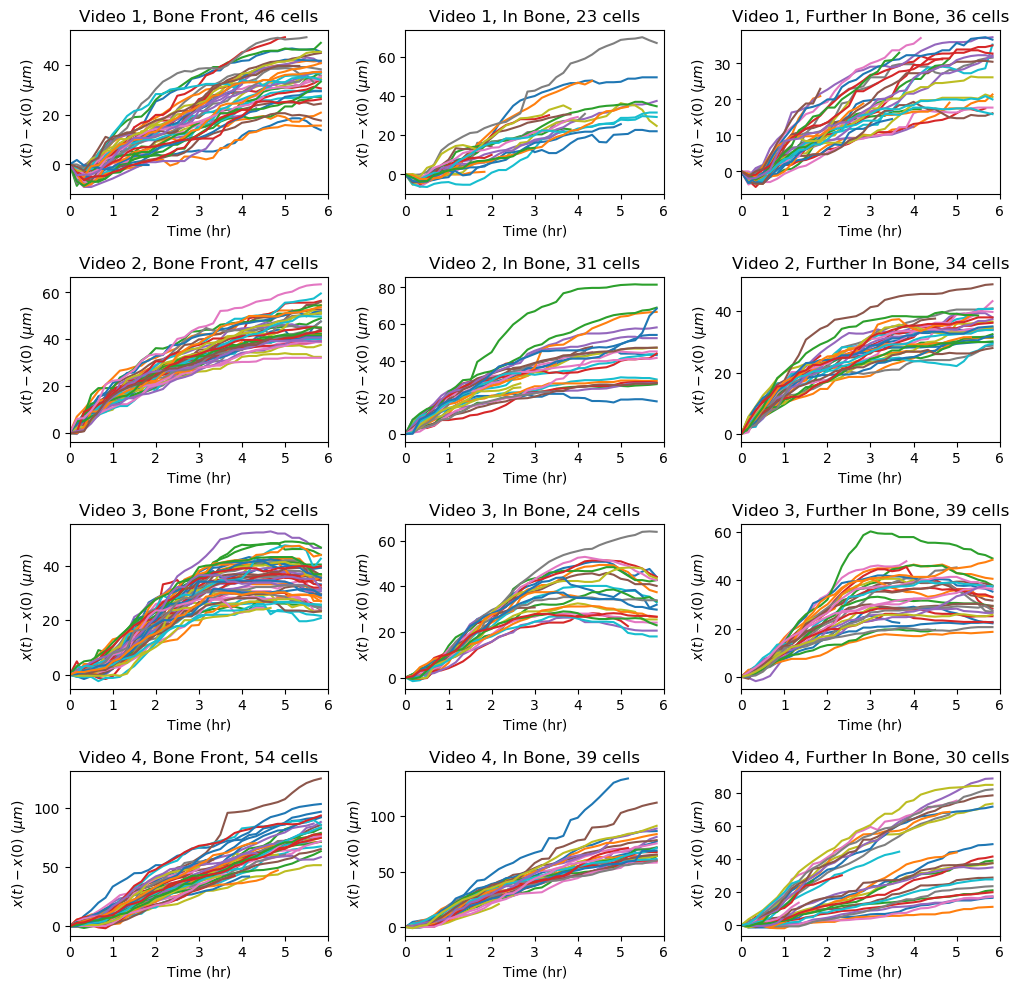

In [41]:
# Plot displacements in horizontal direction vs t
fig, axs = plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)
for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2][:,slice_range];
        N_cells = N_cells_all[i1][i2];
        slices_all = slices_all_all[i1][i2][:,slice_range];
        
        X_displacements = np.array(list(map(lambda x: x-x[0], X_all)))/pix_per_micron; # units: microns
        
        axs[i1, i2].plot(slices_all.T, X_displacements.T)
        #this_title = 'Video {} ({}) {}, {} cells'.format(i1+1, video_labels[i1], names_compare[i2], str(N_cells));
        this_title = 'Video {}, {}, {} cells'.format(i1+1, names_compare[i2], str(N_cells));
        axs[i1, i2].set(xlabel='Time (hr)', ylabel='$x(t) - x(0)$ ($\\mu m$)', title=this_title, xlim=[t_lower, t_upper])

plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show()

Blue shaded area = standard error of the mean
Grey shaded area = standard deviation of data set


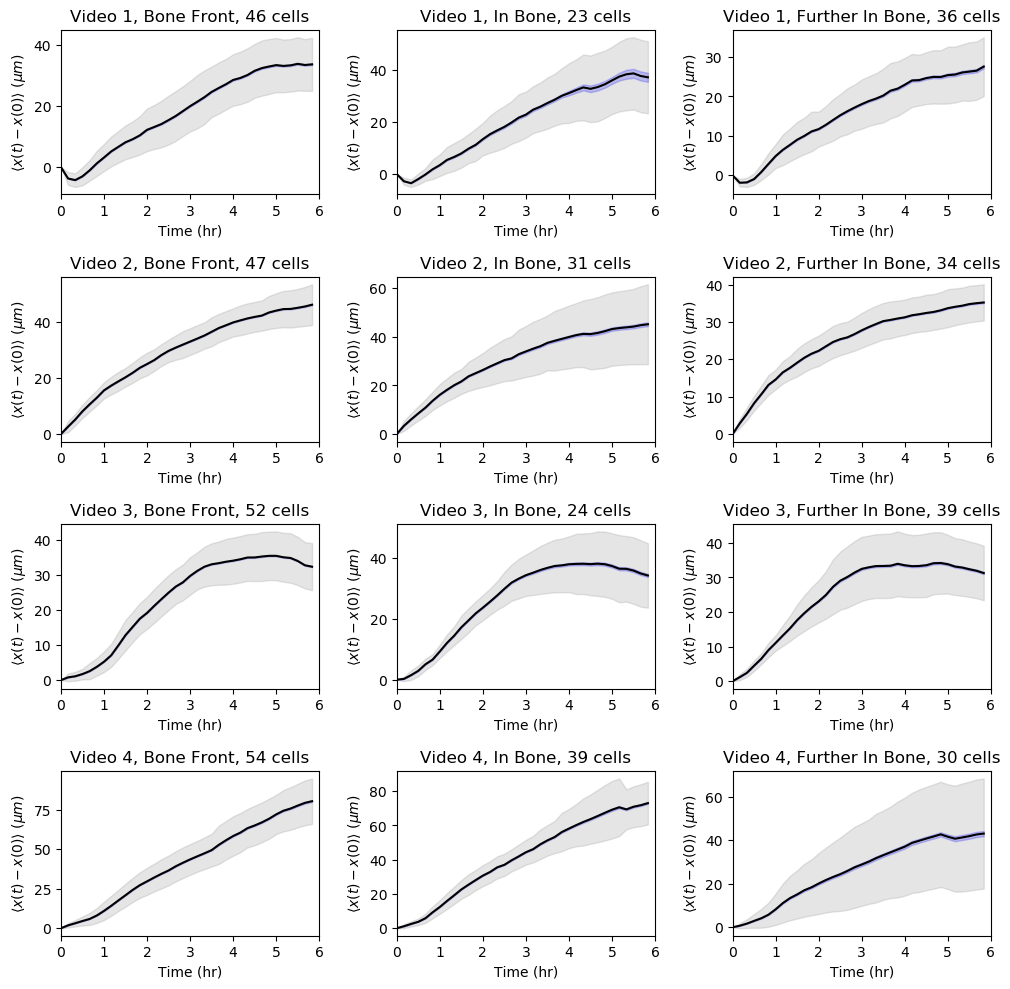

In [42]:
# --- Average over all cells ---
# Store for later 
X_displacements_avg_all = [[None]*N_files_per_video for _ in range(N_videos)];
sem_all_all = [[None]*N_files_per_video for _ in range(N_videos)];

# Plot displacements in horizontal direction vs t
fig, axs = plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)
for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2][:,slice_range];
        N_cells = N_cells_all[i1][i2];
        slices = slices_all_all[i1][i2][0, slice_range];
        
        # Compute mean
        X_displacements = np.array(list(map(lambda x: x-x[0], X_all)))/pix_per_micron; # units: microns
        X_displacements_avg = np.nanmean(X_displacements, axis=0);
        
        # Compute SEM
        std_all = np.nanstd(X_displacements, axis=0); # Std for each time point
        n_all = np.sum(~np.isnan(X_displacements), axis=0); # no. data points per time point
        sem_all = std_all/n_all;
        
        axs[i1, i2].plot(slices, X_displacements_avg, 'k')
        axs[i1, i2].fill_between(slices, X_displacements_avg+std_all, X_displacements_avg-std_all, alpha=0.2, color='gray')
        axs[i1, i2].fill_between(slices, X_displacements_avg+sem_all, X_displacements_avg-sem_all, alpha=0.2, color='b')
        #this_title = 'Video {} ({}) {}, {} cells'.format(i1+1, video_labels[i1], names_compare[i2], str(N_cells));
        this_title = 'Video {}, {}, {} cells'.format(i1+1, names_compare[i2], str(N_cells));
        axs[i1, i2].set(xlabel='Time (hr)', ylabel='$\\langle x(t) - x(0) \\rangle$ ($\\mu m$)', title=this_title, xlim=[t_lower, t_upper])
        
        # store results
        X_displacements_avg_all[i1][i2] = X_displacements_avg;
        sem_all_all[i1][i2] = sem_all;
        
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# print("Net mean velocity over {} hours = {} microns/hr".format(t_upper, round(X_displacements_avg[-1]/t_upper)) )
print("Blue shaded area = standard error of the mean")
print("Grey shaded area = standard deviation of data set")

plt.show()

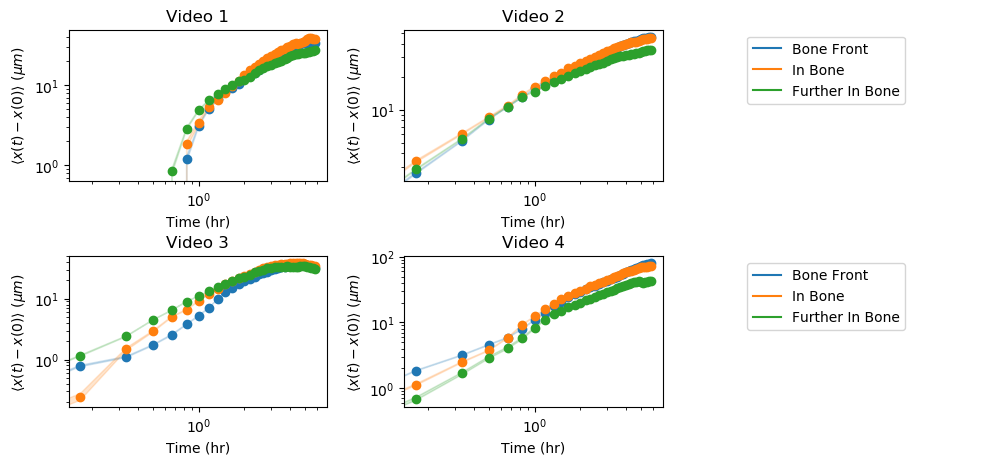

In [43]:
# --- Summary plots: compare locations with each other ---
fig, axs = plt.subplots(2, 3, figsize=(12, 5), dpi=100);

for i1 in range(N_videos):
    [ix, iy] = divmod(i1, 2); # positions of plots
    for i2 in range(N_files_per_video):
        slices = slices_all_all[i1][i2][0, slice_range];
        axs[ix, iy].plot(slices, X_displacements_avg_all[i1][i2], 'o', label=names_compare[i2], color=def_colors[i2])
        axs[ix, iy].fill_between(slices, X_displacements_avg_all[i1][i2]+sem_all_all[i1][i2], X_displacements_avg_all[i1][i2]-sem_all_all[i1][i2], alpha=0.2, color=def_colors[i2])
    
    #this_title='Video {} ({})'.format(i1+1, video_labels[i1]);
    this_title='Video {}'.format(i1+1);
    
    axs[ix, iy].set( title= this_title, xlabel='Time (hr)', ylabel='$\\langle x(t) - x(0) \\rangle$ ($\\mu m$)'  )
    axs[ix, iy].set( yscale = 'log', xscale = 'log');
    #axs[i1].legend();
    
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# ---- Legend ----
#plt.figure(dpi=100, figsize = (2, 1) )
for row in range(2):
    for i, this_label in enumerate(names_compare):
        axs[row, 2].plot(np.nan, label=this_label, color=def_colors[i])
    axs[row, 2].legend(loc='upper left')
    axs[row, 2].axis('off')

plt.show()
#plt.figure(dpi=100, figsize = (2, 1) )
# for i, this_label in enumerate(names_compare):
#     plt.plot(np.nan, label=this_label)
# plt.axis('off')
# plt.legend()
# plt.show()

Compare with Langevin/OU process (Furth's formula): $MSD(t) = 2nD(t - P (1 - e^{-t/P}) ) $. <br>
D: diffusion constant <br>
P: persistence time <br>
n: spatial dimension <br>
Small times ($t \ll P$): $\propto t^2$ <br>
Large times ($t \ll P$): $\propto t$

#### Average over experiments

Bone Front, v=10.49597408356634 microns/hr
In Bone, v=10.490071889949645 microns/hr
Further In Bone, v=7.16217115753735 microns/hr


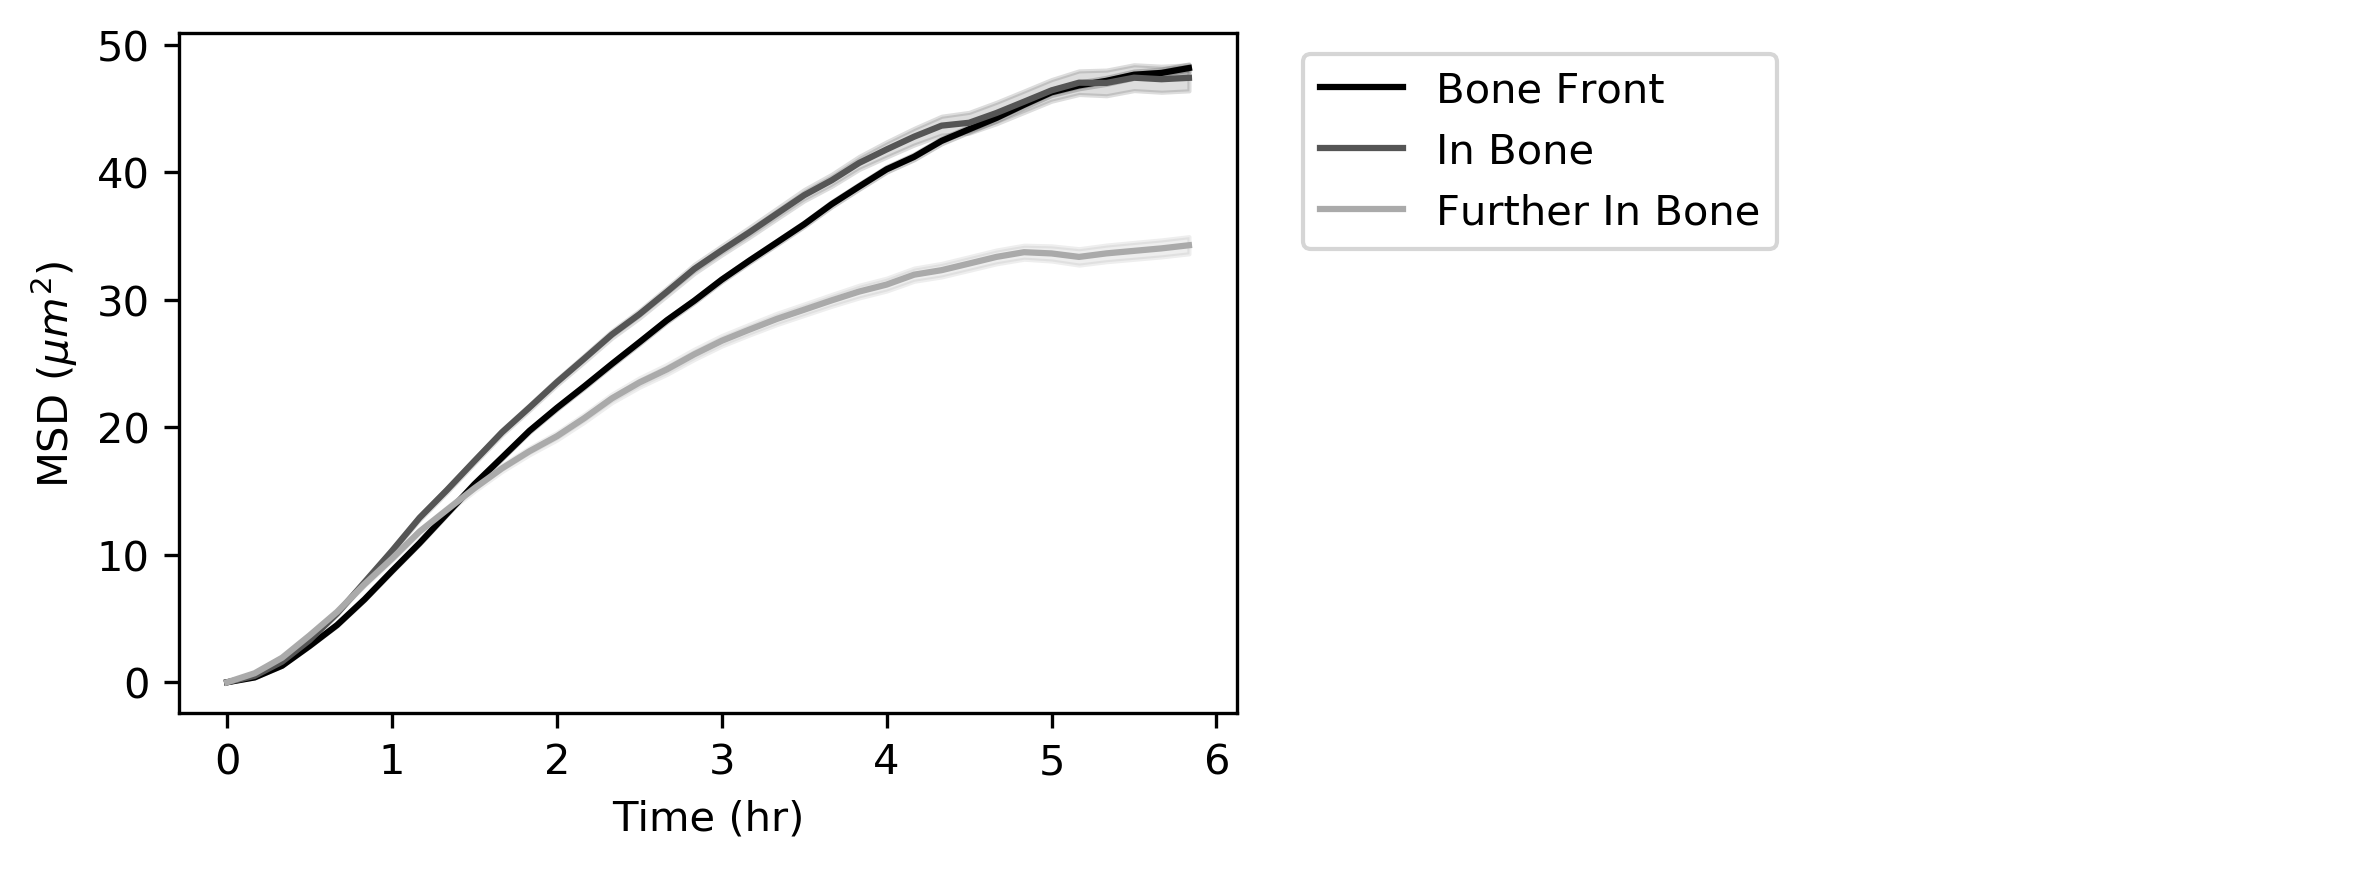

In [48]:
# Plot displacements in horizontal direction vs t
fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

pix_per_micron = pix_per_micron_all[i1];
slices = slices_all_all[0][0][0, slice_range];

for i2 in range(N_files_per_video):
    X_displacements_avg_all_all = np.mean( np.array(X_displacements_avg_all)[:, i2], axis=0 ) # works only if MSD_avg_all has regular sizes!
    sem_all_all_all = np.sqrt( np.sum( np.array(sem_all_all)[:, i2]**2, axis=0 )/N_videos );
    
    axs[0].plot(slices, X_displacements_avg_all_all, label=names_compare[i2], color=colors_cats[i2]); # def_colors / colors_cats
    axs[0].fill_between(slices, X_displacements_avg_all_all-sem_all_all_all, X_displacements_avg_all_all+sem_all_all_all, alpha=0.2, color=colors_cats[i2])
    
    # slopes
    t1 = 1;
    t2 = 4;
    v2 = (X_displacements_avg_all_all[t2*6] - X_displacements_avg_all_all[t1*6])/(t2-t1);
    print("{}, v={} microns/hr".format(names_compare[i2], v2, np.sqrt(v2)) )
axs[0].set( xlabel='Time (hr)', ylabel='MSD ($\\mu m^2$)'  )

#plt.figure(dpi=100, figsize = (2, 1) )
for i, this_label in enumerate(names_compare):
    axs[1].plot(np.nan, label=this_label, color=colors_cats[i])
axs[1].legend(loc='upper left')
axs[1].axis('off')
     
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()

plt.show()

### Save analyzed data

In [15]:
# Save analyzed displacement profiles for comparison
save_folder = "/Users/dang/Documents/TablerLab/Data_Adrian_cell_tracks/";
for i1 in range(N_videos):
    for i2 in range(N_files_per_video):
        video_label = video_labels[i1];
        name_label = names_compare[i2];
        
        data_out = np.array([X_displacements_avg_all[i1][i2], sem_all_all[i1][i2]])
        
        fname_out = "Analyze_single_cell_tracks_X_displacements_avg_all_video_{}_{}_{}.csv".format(i1+1, video_label, name_label);
        X_displacements_out = pd.DataFrame(data_out.T, columns=["mean_displacement", "SEM"]);
        #X_displacements_out.to_csv(save_folder + fname_out)        